In [0]:
!pip install hyperas
!pip install hyperopt

In [3]:
from __future__ import print_function
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

import math
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm
    
from imblearn.combine import SMOTEENN

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("/content/drive/My Drive/Marketing Analytics")
print(os.listdir(os.getcwd())) 
         

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/bin/bash: google-drive-ocamlfuse: command not found
['advertising_spend_data.xlsx', 'subscribers', 'engagement', 'customer_service_reps', 'Final_code (1).ipynb', 'drive', 'CAC.csv', 'mean_converted.csv', 'Final_code_Wayne.ipynb', 'eng_whole.csv', 'eng_sub.csv', 'Log_ROC.png', 'prediction_set.csv', 'rev_churn_cost.csv', 'Middle Eastern Video on Demand.gslides', 'final.ipynb']


In [0]:
subscribers = pd.read_pickle('subscribers')
engagement = pd.read_pickle('engagement')
service = pd.read_pickle('customer_service_reps')

# Descriptive Analysis and Preprocessing


## Subscriber

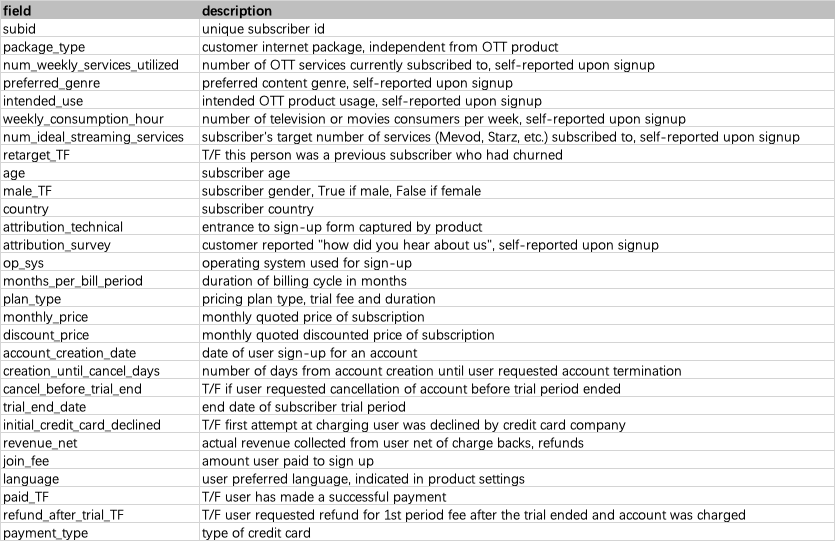

In [0]:
subscribers.loc[(subscribers['retarget_TF'] == False),'retarget_TF']= 0
subscribers.loc[(subscribers['retarget_TF'] == True),'retarget_TF']= 1
subscribers['retarget_TF'] = subscribers['retarget_TF'].astype('int')

subscribers.loc[(subscribers['male_TF'] == False),'male_TF']= 0
subscribers.loc[(subscribers['male_TF'] == True),'male_TF']= 1
#subscribers['male_TF'] = subscribers['male_TF'].astype('int')

subscribers.loc[(subscribers['cancel_before_trial_end'] == False),'cancel_before_trial_end']= 0
subscribers.loc[(subscribers['cancel_before_trial_end'] == True),'cancel_before_trial_end']= 1
subscribers['cancel_before_trial_end'] = subscribers['cancel_before_trial_end'].astype('int')

subscribers.loc[(subscribers['initial_credit_card_declined'] == False),'initial_credit_card_declined']= 0
subscribers.loc[(subscribers['initial_credit_card_declined'] == True),'initial_credit_card_declined']= 1
subscribers['initial_credit_card_declined'] = subscribers['initial_credit_card_declined'].astype('int')

subscribers.loc[(subscribers['paid_TF'] == False),'paid_TF']= 0
subscribers.loc[(subscribers['paid_TF'] == True),'paid_TF']= 1
subscribers['paid_TF'] = subscribers['paid_TF'].astype('int')

subscribers.loc[(subscribers['refund_after_trial_TF'] == False),'refund_after_trial_TF']= 0
subscribers.loc[(subscribers['refund_after_trial_TF'] == True),'refund_after_trial_TF']= 1
subscribers['refund_after_trial_TF'] = subscribers['refund_after_trial_TF'].astype('int')

In [0]:
subscribers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227628 entries, 162502 to 598241
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   subid                         227628 non-null  int64         
 1   package_type                  192054 non-null  object        
 2   num_weekly_services_utilized  117178 non-null  float64       
 3   preferred_genre               191302 non-null  object        
 4   intended_use                  224079 non-null  object        
 5   weekly_consumption_hour       189698 non-null  float64       
 6   num_ideal_streaming_services  115458 non-null  float64       
 7   retarget_TF                   227628 non-null  int64         
 8   age                           192459 non-null  float64       
 9   male_TF                       227359 non-null  object        
 10  country                       227628 non-null  object        
 11  attribut

In [0]:
subscribers.describe(include='all')

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
count,2.276280e+05,192054,117178.000000,191302,224079,189698.000000,115458.000000,227628,191505.000000,227359,227628,227628,224984,214253,227628.0,227628,227628.000000,227628.000000,227628,151768.000000,227628,227628,227628,192724.000000,192724.000000,227628,227628,227628,92050
unique,NaN,3,NaN,5,7,NaN,NaN,2,NaN,2,1,33,16,2,NaN,11,NaN,NaN,226023,NaN,2,272,2,NaN,NaN,1,2,2,6
top,NaN,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,iOS,NaN,base_uae_14_day_trial,NaN,NaN,2019-11-17 16:24:52,NaN,False,2019-07-16 00:00:00,False,NaN,NaN,ar,False,False,Standard Charter
freq,NaN,111464,NaN,125129,89039,NaN,NaN,219825,NaN,200902,227628,80251,119126,143921,NaN,227096,NaN,NaN,3,NaN,124071,2866,216425,NaN,NaN,227628,135578,218383,38810
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 00:00:19,NaN,NaN,2019-07-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-27 23:59:06,NaN,NaN,2020-04-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.498624e+07,NaN,2.998568,NaN,NaN,27.997724,1.999848,NaN,46.174421,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.732049,4.512188,NaN,16.570832,NaN,NaN,NaN,1.557353,0.115145,NaN,NaN,NaN,NaN
std,2.885543e+06,NaN,0.748752,NaN,NaN,4.976341,0.249508,NaN,13.955719,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.101049,0.097078,NaN,35.777986,NaN,NaN,NaN,3.068829,0.176971,NaN,NaN,NaN,NaN
min,2.000001e+07,NaN,0.049049,NaN,NaN,-32.146760,-0.919933,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,4.0,NaN,0.807400,0.770700,NaN,-108.000000,NaN,NaN,NaN,-5.982100,-0.660600,NaN,NaN,NaN,NaN
25%,2.248998e+07,NaN,2.493926,NaN,NaN,24.401536,1.867354,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.734300,4.514100,NaN,2.000000,NaN,NaN,NaN,0.000000,0.036700,NaN,NaN,NaN,NaN


In [0]:
subscribers.loc[(subscribers['age'] >= 100),'age']=np.nan
subscribers.loc[(subscribers['age'] < 10),'age']=np.nan

In [0]:
subscribers

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,UAE,facebook,facebook_organic,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-11-17 14:12:33,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,UAE,google_organic,referral,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-06 18:02:13,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,UAE,facebook,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-21 19:40:44,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-17 23:58:51,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [0]:
subscribers['account_creation_date'].sort_values()

647704   2019-06-30 00:00:19
67954    2019-06-30 00:00:47
378123   2019-06-30 00:00:51
90143    2019-06-30 00:01:25
382402   2019-06-30 00:01:31
                 ...        
218040   2020-03-27 23:52:29
306223   2020-03-27 23:53:40
425094   2020-03-27 23:54:17
575153   2020-03-27 23:58:49
537732   2020-03-27 23:59:06
Name: account_creation_date, Length: 227628, dtype: datetime64[ns]

In [0]:
subscribers['male_TF'].value_counts()

0    200902
1     26457
Name: male_TF, dtype: int64

In [0]:
subscribers['preferred_genre'].value_counts()

comedy           125129
drama             46872
regional           8990
international      6404
other              3907
Name: preferred_genre, dtype: int64

In [0]:
subscribers['intended_use'].value_counts()

access to exclusive content    89039
replace OTT                    69185
supplement OTT                 26603
expand regional access         14025
expand international access    12978
other                           7112
education                       5137
Name: intended_use, dtype: int64

In [0]:
subscribers['package_type'].value_counts()

base        111464
enhanced     63241
economy      17349
Name: package_type, dtype: int64

In [0]:
subscribers['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
high_jpy_14_day_trial                     1
base_uae_no_trial_7_day_guarantee         1
low_sar_no_trial                          1
low_eur_no_trial                          1
Name: plan_type, dtype: int64

In [0]:
subscribers['attribution_technical'].value_counts()

facebook                   80251
email                      25690
search                     25306
organic                    22013
brand sem intent google    18524
google_organic             10691
affiliate                   9894
email_blast                 7277
pinterest                   6065
referral                    5170
facebook_organic            3272
discovery                   2571
brand sem intent bing       2231
other                       1786
display                     1407
bing                        1146
internal                    1122
podcast                      985
youtube                      913
bing_organic                 369
vod                          297
ott                          158
direct_mail                  139
quora                        100
samsung                       86
appstore                      44
criteo                        44
pinterest_organic             30
influencer                    21
playstore                     12
twitter   

In [0]:
subscribers['attribution_survey'].value_counts()

facebook            119126
tv                   39904
referral             20882
search                8492
pinterest             7856
other                 6496
public_radio          6219
social_organic        3869
youtube               3108
podcast               2995
affiliate             1962
ott                   1443
sirius xm             1122
facebook_organic       765
direct_mail            408
amfm_radio             337
Name: attribution_survey, dtype: int64

## Engagement

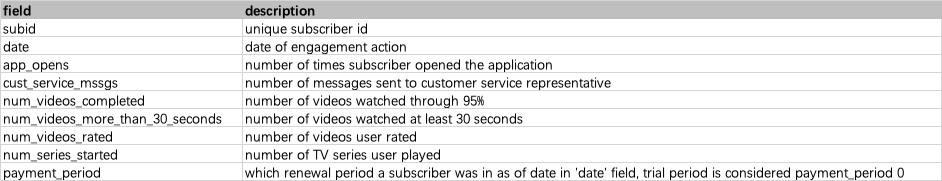


In [0]:
engagement

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28832315,28409777,2020-04-21,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832317,28409777,2020-04-22,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832319,28409777,2020-04-23,0.0,0.0,4.0,4.0,0.0,1.0,1.0
28832321,28409777,2020-04-24,1.0,0.0,3.0,4.0,1.0,1.0,1.0


In [0]:
engagement.describe(include='all')

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
count,2.585724e+06,2585724,2.551113e+06,2.551113e+06,2.551113e+06,2.551113e+06,2.551113e+06,2.551113e+06,2.585724e+06
unique,NaN,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2020-03-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,14016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2019-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-04-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.499102e+07,NaN,2.247702e+00,3.896170e-01,2.794718e+00,4.394189e+00,5.889939e-02,6.860515e-01,6.747735e-01
std,2.891154e+06,NaN,2.433315e+00,8.061742e-01,2.212746e+00,1.453039e+00,2.800921e-01,4.643331e-01,7.088157e-01
min,2.000006e+07,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.248173e+07,NaN,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [0]:
engagement.isna().sum()

subid                                  0
date                                   0
app_opens                          34611
cust_service_mssgs                 34611
num_videos_completed               34611
num_videos_more_than_30_seconds    34611
num_videos_rated                   34611
num_series_started                 34611
payment_period                         0
dtype: int64

In [0]:
# only period 3 has missing values, drop them 
engagement.loc[(engagement['app_opens'].isnull()==True),'payment_period'].value_counts()

3.0    34611
Name: payment_period, dtype: int64

In [0]:
engagement.loc[(engagement['app_opens'].isnull()==True),'subid'].nunique()

1612

In [0]:
engagement = engagement.loc[(engagement['app_opens'].isnull()==False)]

### construct variable -- "duration" and "active days"



In [0]:
pd.set_option('display.max_rows', None)
engagement.loc[engagement['subid']==29999889]
## Found that the payment period in engagement data is 1-month instead of 4-month

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
17252216,29999889,2019-08-23,2.0,2.0,7.0,7.0,0.0,1.0,0.0
17252219,29999889,2019-08-24,2.0,0.0,6.0,6.0,0.0,1.0,0.0
17252222,29999889,2019-08-25,4.0,1.0,5.0,5.0,0.0,1.0,0.0
17252225,29999889,2019-08-26,4.0,0.0,5.0,5.0,0.0,1.0,0.0
17252228,29999889,2019-08-27,1.0,4.0,5.0,5.0,0.0,1.0,0.0
17252231,29999889,2019-08-28,4.0,0.0,4.0,4.0,0.0,1.0,0.0
17252234,29999889,2019-08-29,3.0,0.0,5.0,5.0,0.0,1.0,0.0
17252237,29999889,2019-08-30,4.0,0.0,5.0,5.0,0.0,1.0,0.0
17252256,29999889,2019-08-31,2.0,0.0,4.0,4.0,0.0,1.0,0.0
17252259,29999889,2019-09-01,1.0,0.0,4.0,4.0,0.0,1.0,0.0


In [0]:
pd.set_option('display.max_rows', 50)

In [0]:
duration =  engagement.groupby(['subid','payment_period'])['date'].apply(lambda x: (max(x) - min(x)).days + 1)

In [0]:
duration_df = pd.DataFrame(duration)
duration_df.columns = ['duration']
duration_df

duration
subid    payment_period          
20000062 0.0                    5
20000405 0.0                   11
20000604 0.0                   15
         1.0                   11
20000685 0.0                   15
...                           ...
29999889 0.0                   15
         1.0                   31
         2.0                   30
29999945 0.0                   15
         1.0                   26

[200843 rows x 1 columns]

In [0]:
duration_df.groupby(['payment_period'])['duration'].max()

payment_period
0.0    15
1.0    31
2.0    30
3.0    31
Name: duration, dtype: int64

In [0]:
engagement.columns

Index(['subid', 'date', 'app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started', 'payment_period'],
      dtype='object')

In [0]:
count_activedays = engagement.groupby(['subid','payment_period'])['date'].agg('count')
activedays = count_activedays.to_frame()
activedays.columns = ['active_days']
activedays

active_days
subid    payment_period             
20000062 0.0                       4
20000405 0.0                       4
20000604 0.0                      13
         1.0                       2
20000685 0.0                      13
...                              ...
29999889 0.0                      15
         1.0                      31
         2.0                      30
29999945 0.0                      15
         1.0                      22

[200843 rows x 1 columns]

In [0]:
activedays.reset_index(level=1, inplace=True)
activedays.reset_index(level=0, inplace=True)

In [0]:
activedays

,subid,payment_period,active_days
0,20000062,0.0,4
1,20000405,0.0,4
2,20000604,0.0,13
3,20000604,1.0,2
4,20000685,0.0,13
...,...,...,...
202443,29999889,0.0,15
202444,29999889,1.0,31
202445,29999889,2.0,30
202446,29999945,0.0,15


In [0]:
activedays.groupby(['payment_period'])['active_days'].agg(['min','max'])

,min,max
payment_period,,
0.0,1,15
1.0,1,31
2.0,1,30
3.0,1,31


### aggregate on customer behavior features

In [0]:
mean_sum = engagement.groupby(['subid','payment_period'])['app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started'].agg('sum')

mean_sum

app_opens  ...  num_series_started
subid    payment_period             ...                    
20000062 0.0                   4.0  ...                 1.0
20000405 0.0                   5.0  ...                 1.0
20000604 0.0                  13.0  ...                 1.0
         1.0                   1.0  ...                 0.0
20000685 0.0                  17.0  ...                 7.0
...                            ...  ...                 ...
29999889 0.0                  44.0  ...                15.0
         1.0                 130.0  ...                23.0
         2.0                  71.0  ...                30.0
29999945 0.0                  13.0  ...                11.0
         1.0                  23.0  ...                16.0

[200843 rows x 6 columns]

In [0]:
mean_sum.reset_index(level=1, inplace=True)
mean_sum.reset_index(level=0, inplace=True)

In [0]:
mean_sum

,subid,payment_period,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
0,20000062,0.0,4.0,3.0,6.0,23.0,0.0,1.0
1,20000405,0.0,5.0,4.0,13.0,17.0,0.0,1.0
2,20000604,0.0,13.0,4.0,8.0,64.0,0.0,1.0
3,20000604,1.0,1.0,1.0,0.0,4.0,0.0,0.0
4,20000685,0.0,17.0,4.0,11.0,63.0,0.0,7.0
...,...,...,...,...,...,...,...,...
200838,29999889,0.0,44.0,14.0,74.0,74.0,0.0,15.0
200839,29999889,1.0,130.0,15.0,132.0,132.0,20.0,23.0
200840,29999889,2.0,71.0,16.0,120.0,120.0,20.0,30.0
200841,29999945,0.0,13.0,2.0,63.0,72.0,0.0,11.0


In [0]:
eng = pd.merge(duration_df,mean_sum,on=['subid','payment_period'], how='right')
eng = pd.merge(activedays,eng,on=['subid','payment_period'], how='right')
eng

,subid,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
0,20000062,0.0,4,5,4.0,3.0,6.0,23.0,0.0,1.0
1,20000405,0.0,4,11,5.0,4.0,13.0,17.0,0.0,1.0
2,20000604,0.0,13,15,13.0,4.0,8.0,64.0,0.0,1.0
3,20000604,1.0,2,11,1.0,1.0,0.0,4.0,0.0,0.0
4,20000685,0.0,13,15,17.0,4.0,11.0,63.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...
200838,29999889,0.0,15,15,44.0,14.0,74.0,74.0,0.0,15.0
200839,29999889,1.0,31,31,130.0,15.0,132.0,132.0,20.0,23.0
200840,29999889,2.0,30,30,71.0,16.0,120.0,120.0,20.0,30.0
200841,29999945,0.0,15,15,13.0,2.0,63.0,72.0,0.0,11.0


### label "current users"


In [0]:
# try to label whether someone is still using the service up to date 2020-04-25

engagement['date'].sort_values()

1598457    2019-06-30
16835004   2019-06-30
276647     2019-06-30
80711      2019-06-30
16696561   2019-06-30
              ...    
27795561   2020-04-25
13665557   2020-04-25
7532562    2020-04-25
13785032   2020-04-25
28832323   2020-04-25
Name: date, Length: 2551113, dtype: datetime64[ns]

In [0]:
newest_date = engagement.groupby(['subid','payment_period'])['date'].agg(['min','max'])
#newest_date_df = newest_date.to_frame()
#newest_date_df.columns = ['newest_date']
newest_date

min        max
subid    payment_period                      
20000062 0.0            2019-06-30 2019-07-04
20000405 0.0            2020-03-08 2020-03-18
20000604 0.0            2020-02-09 2020-02-23
         1.0            2020-02-24 2020-03-05
20000685 0.0            2020-03-03 2020-03-17
...                            ...        ...
29999889 0.0            2019-08-23 2019-09-06
         1.0            2019-09-07 2019-10-07
         2.0            2019-10-08 2019-11-06
29999945 0.0            2020-03-14 2020-03-28
         1.0            2020-03-29 2020-04-23

[200843 rows x 2 columns]

In [0]:
newest_date.reset_index(level=1, inplace=True)
newest_date.reset_index(level=0, inplace=True)

In [0]:
newest_date.drop_duplicates(subset='subid', keep="last", inplace=True)

In [0]:
newest_date.rename(columns={'payment_period':'newest_period',
                          'min':'min_date',
                          'max':'max_date'}, 
                 inplace=True)

In [0]:
newest_date

,subid,newest_period,min_date,max_date
0,20000062,0.0,2019-06-30,2019-07-04
1,20000405,0.0,2020-03-08,2020-03-18
3,20000604,1.0,2020-02-24,2020-03-05
5,20000685,1.0,2020-03-18,2020-04-15
6,20000741,0.0,2019-08-25,2019-08-26
...,...,...,...,...
200835,29999740,0.0,2019-07-11,2019-07-25
200836,29999820,0.0,2019-09-22,2019-10-01
200837,29999822,0.0,2019-11-22,2019-12-03
200840,29999889,2.0,2019-10-08,2019-11-06


In [0]:
# check whether the 'newest_date' is consistent with feature 'current_sub_TF' in the service dataset

current_user = pd.merge(service,newest_date,on=['subid'], how='right')
current_user

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew,newest_period,min_date,max_date,current_user
0,30034436,21697364,False,2020-04-08 13:16:39,2020-03-27 23:59:06,14,False,OTT,0.0000,0,2020-03-28 00:05:20,NaT,False,0.0,2020-03-27,2020-04-08,0
1,34138852,20407871,False,2020-04-01 05:42:28,2020-03-27 23:58:49,14,False,OTT,0.0000,0,2020-03-27 23:58:49,NaT,False,0.0,2020-03-27,2020-04-01,0
2,33808892,27818002,False,2020-04-08 22:00:59,2020-03-27 23:53:40,14,False,OTT,0.0000,0,2020-03-28 00:05:20,NaT,False,0.0,2020-03-27,2020-04-08,0
3,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,1.0,2020-04-11,2020-04-25,1
4,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,1,2020-04-11 14:22:46,NaT,False,1.0,2020-04-11,2020-04-25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209854,34410719,29969407,False,2019-07-07 14:15:50,2019-06-30 00:01:31,14,False,OTT,0.0000,0,2019-06-30 01:05:36,NaT,False,0.0,2019-06-30,2019-07-07,0
209855,38865556,27585257,False,NaT,2019-06-30 00:01:25,14,True,OTT,4.9178,0,2019-06-30 00:01:25,2019-07-14 14:33:09,True,1.0,2019-07-15,2019-08-14,0
209856,38865556,27585257,False,NaT,2019-06-30 00:01:25,14,True,OTT,4.9178,1,2019-07-14 14:33:09,NaT,False,1.0,2019-07-15,2019-08-14,0
209857,30947283,26986758,False,2019-07-12 23:23:24,2019-06-30 00:00:51,14,False,OTT,0.0000,0,2019-06-30 01:05:29,NaT,False,0.0,2019-06-30,2019-07-12,0


In [0]:
current_user.loc[(current_user['current_sub_TF']==True)]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew,newest_period,min_date,max_date,current_user
3,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,1.0,2020-04-11,2020-04-25,1
4,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,1,2020-04-11 14:22:46,NaT,False,1.0,2020-04-11,2020-04-25,1
5,31714601,20162910,True,NaT,2020-03-27 23:51:37,14,True,OTT,4.5875,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,1.0,2020-04-11,2020-04-23,1
6,31714601,20162910,True,NaT,2020-03-27 23:51:37,14,True,OTT,4.5875,1,2020-04-11 14:22:46,NaT,False,1.0,2020-04-11,2020-04-23,1
9,33630522,22120282,True,NaT,2020-03-27 23:47:11,14,True,OTT,4.8811,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,1.0,2020-04-12,2020-04-18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209849,36080216,27196054,True,NaT,2019-06-30 00:01:56,14,True,OTT,4.5875,3,2020-03-13 14:01:42,NaT,False,3.0,2019-10-02,2019-10-14,0
209850,30967722,26531005,True,NaT,2019-06-30 00:01:45,14,True,OTT,3.4498,0,2019-06-30 01:05:37,2019-07-14 11:06:54,True,3.0,2019-09-14,2019-09-27,0
209851,30967722,26531005,True,NaT,2019-06-30 00:01:45,14,True,OTT,3.4498,1,2019-07-14 11:06:54,2019-11-11 11:05:20,True,3.0,2019-09-14,2019-09-27,0
209852,30967722,26531005,True,NaT,2019-06-30 00:01:45,14,True,OTT,3.4498,2,2019-11-11 11:05:20,2020-03-13 11:05:22,True,3.0,2019-09-14,2019-09-27,0


In [184]:
pd.set_option('display.max_rows', 80)
s = engagement.loc[engagement['subid']==26531005]
s.set_index(keys = ['subid'],drop = True,inplace=True)
s['Date'] = s['date']
s.iloc[:,7:]

,payment_period,Date
subid,,
26531005,0.0,2019-06-30
26531005,0.0,2019-07-01
26531005,0.0,2019-07-02
26531005,0.0,2019-07-03
26531005,0.0,2019-07-04
26531005,0.0,2019-07-05
26531005,0.0,2019-07-06
26531005,0.0,2019-07-07
26531005,0.0,2019-07-08


In [189]:
s_2 = service.drop(columns=['current_sub_TF', 'cancel_date',
       'account_creation_date', 'num_trial_days', 'trial_completed_TF',
       'billing_channel', 'revenue_net_1month'],inplace=False)
s_2.loc[s_2['subid']==26531005]

,customer_service_rep_id,subid,payment_period,last_payment,next_payment,renew
2248366,30967722,26531005,0,2019-06-30 01:05:37,2019-07-14 11:06:54,True
2248367,30967722,26531005,1,2019-07-14 11:06:54,2019-11-11 11:05:20,True
2248368,30967722,26531005,2,2019-11-11 11:05:20,2020-03-13 11:05:22,True
2248369,30967722,26531005,3,2020-03-13 11:05:22,NaT,False


In [0]:
current_user.loc[(current_user['current_sub_TF']==True),'min_date'].value_counts()

2020-03-28    944
2020-03-21    921
2020-01-14    847
2020-03-22    843
2020-03-23    820
             ... 
2019-07-12      8
2020-04-22      8
2020-04-19      8
2020-04-21      6
2020-04-25      4
Name: min_date, Length: 301, dtype: int64

In [0]:
current_user.loc[(current_user['current_sub_TF']==True)&(current_user['min_date']<'2020-03-24'),'min_date'].value_counts()

2020-03-21    921
2020-01-14    847
2020-03-22    843
2020-03-23    820
2020-01-11    792
             ... 
2019-07-10     12
2019-08-26     11
2019-08-03     11
2019-07-09      9
2019-07-12      8
Name: min_date, Length: 268, dtype: int64

In [0]:
newest_date

,subid,newest_period,min_date,max_date
0,20000062,0.0,2019-06-30,2019-07-04
1,20000405,0.0,2020-03-08,2020-03-18
3,20000604,1.0,2020-02-24,2020-03-05
5,20000685,1.0,2020-03-18,2020-04-15
6,20000741,0.0,2019-08-25,2019-08-26
...,...,...,...,...
200835,29999740,0.0,2019-07-11,2019-07-25
200836,29999820,0.0,2019-09-22,2019-10-01
200837,29999822,0.0,2019-11-22,2019-12-03
200840,29999889,2.0,2019-10-08,2019-11-06


In [0]:
# Since the 'newest_date' is not consistent with feature 'current_sub_TF' in the service dataset, define 'current_user' myself
newest_date['current_user'] = 0
newest_date.loc[(newest_date['min_date']>='2020-03-25')&(newest_date['newest_period']!=0),'current_user'] = 1
newest_date

,subid,newest_period,min_date,max_date,current_user
0,20000062,0.0,2019-06-30,2019-07-04,0
1,20000405,0.0,2020-03-08,2020-03-18,0
3,20000604,1.0,2020-02-24,2020-03-05,0
5,20000685,1.0,2020-03-18,2020-04-15,0
6,20000741,0.0,2019-08-25,2019-08-26,0
...,...,...,...,...,...
200835,29999740,0.0,2019-07-11,2019-07-25,0
200836,29999820,0.0,2019-09-22,2019-10-01,0
200837,29999822,0.0,2019-11-22,2019-12-03,0
200840,29999889,2.0,2019-10-08,2019-11-06,0


In [0]:
newest_date.loc[(newest_date['newest_period']==1)&(newest_date['current_user']==1)]

,subid,newest_period,min_date,max_date,current_user
123,20005571,1.0,2020-03-29,2020-04-24,1
160,20007878,1.0,2020-04-06,2020-04-23,1
409,20019337,1.0,2020-03-25,2020-04-24,1
532,20024839,1.0,2020-04-03,2020-04-25,1
612,20028948,1.0,2020-04-02,2020-04-25,1
...,...,...,...,...,...
200757,29995579,1.0,2020-03-29,2020-04-06,1
200789,29997578,1.0,2020-03-27,2020-04-25,1
200808,29998441,1.0,2020-04-14,2020-04-20,1
200814,29998629,1.0,2020-04-11,2020-04-11,1


In [0]:
eng = pd.merge(newest_date,eng,on=['subid'], how='right')
eng

,subid,newest_period,min_date,max_date,current_user,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
0,20000062,0.0,2019-06-30,2019-07-04,0,0.0,4,5,4.0,3.0,6.0,23.0,0.0,1.0
1,20000405,0.0,2020-03-08,2020-03-18,0,0.0,4,11,5.0,4.0,13.0,17.0,0.0,1.0
2,20000604,1.0,2020-02-24,2020-03-05,0,0.0,13,15,13.0,4.0,8.0,64.0,0.0,1.0
3,20000604,1.0,2020-02-24,2020-03-05,0,1.0,2,11,1.0,1.0,0.0,4.0,0.0,0.0
4,20000685,1.0,2020-03-18,2020-04-15,0,0.0,13,15,17.0,4.0,11.0,63.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200838,29999889,2.0,2019-10-08,2019-11-06,0,0.0,15,15,44.0,14.0,74.0,74.0,0.0,15.0
200839,29999889,2.0,2019-10-08,2019-11-06,0,1.0,31,31,130.0,15.0,132.0,132.0,20.0,23.0
200840,29999889,2.0,2019-10-08,2019-11-06,0,2.0,30,30,71.0,16.0,120.0,120.0,20.0,30.0
200841,29999945,1.0,2020-03-29,2020-04-23,1,0.0,15,15,13.0,2.0,63.0,72.0,0.0,11.0


In [0]:
eng.drop(columns = ['min_date','max_date'],inplace = True)

In [0]:
# number of current users
eng.loc[(eng['current_user']==1),'subid'].nunique()

4098

In [0]:
eng_current = eng.loc[eng['current_user']==1]

In [0]:
eng_current = eng_current.loc[eng_current['payment_period']==1]

In [0]:
eng_current

,subid,newest_period,current_user,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started
123,20005571,1.0,1,1.0,27,27,53.0,12.0,53.0,111.0,1.0,22.0
160,20007878,1.0,1,1.0,8,18,9.0,4.0,0.0,31.0,0.0,0.0
409,20019337,1.0,1,1.0,31,31,85.0,0.0,4.0,132.0,0.0,28.0
532,20024839,1.0,1,1.0,23,23,24.0,0.0,93.0,100.0,0.0,23.0
612,20028948,1.0,1,1.0,24,24,24.0,15.0,94.0,100.0,10.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
200757,29995579,1.0,1,1.0,2,9,2.0,0.0,0.0,8.0,0.0,0.0
200789,29997578,1.0,1,1.0,30,30,31.0,19.0,114.0,128.0,15.0,29.0
200808,29998441,1.0,1,1.0,2,7,2.0,0.0,0.0,8.0,0.0,0.0
200814,29998629,1.0,1,1.0,1,1,2.0,3.0,0.0,4.0,0.0,0.0


In [0]:
eng = eng.loc[eng['current_user']!=1]

### label "churn"


In [0]:
eng['pass_0'] = eng['payment_period'] == 1
mapping = eng.groupby(by='subid')['pass_0'].agg(max)
eng['converted_on_0'] = eng['subid'].map(mapping)

In [0]:
eng['pass_1'] = eng['payment_period'] == 2
mapping_2 = eng.groupby(by='subid')['pass_1'].agg(max)
eng['converted_on_1'] = eng['subid'].map(mapping_2)

In [0]:
eng['pass_2'] = eng['payment_period'] == 3
mapping_3 = eng.groupby(by='subid')['pass_2'].agg(max)
eng['converted_on_2'] = eng['subid'].map(mapping_3)
eng

,subid,newest_period,current_user,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,pass_0,converted_on_0,pass_1,converted_on_1,pass_2,converted_on_2
0,20000062,0.0,0,0.0,4,5,4.0,3.0,6.0,23.0,0.0,1.0,False,False,False,False,False,False
1,20000405,0.0,0,0.0,4,11,5.0,4.0,13.0,17.0,0.0,1.0,False,False,False,False,False,False
2,20000604,1.0,0,0.0,13,15,13.0,4.0,8.0,64.0,0.0,1.0,False,True,False,False,False,False
3,20000604,1.0,0,1.0,2,11,1.0,1.0,0.0,4.0,0.0,0.0,True,True,False,False,False,False
4,20000685,1.0,0,0.0,13,15,17.0,4.0,11.0,63.0,0.0,7.0,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200836,29999820,0.0,0,0.0,10,10,12.0,6.0,22.0,50.0,0.0,7.0,False,False,False,False,False,False
200837,29999822,0.0,0,0.0,5,12,5.0,4.0,2.0,25.0,0.0,1.0,False,False,False,False,False,False
200838,29999889,2.0,0,0.0,15,15,44.0,14.0,74.0,74.0,0.0,15.0,False,True,False,True,False,False
200839,29999889,2.0,0,1.0,31,31,130.0,15.0,132.0,132.0,20.0,23.0,True,True,False,True,False,False


In [0]:
# Drop those who don't have continuous payment period
eng.drop(eng[(eng['converted_on_1']==True)&(eng['converted_on_0']==False)].index, inplace=True)
eng.drop(eng[(eng['converted_on_2']==True)&(eng['converted_on_1']==False)].index, inplace=True)

In [0]:
# number of people converted on period 0
eng.loc[(eng['converted_on_0']==True),'subid'].nunique()

49620

In [0]:
# number of people churn on period 1
eng.loc[(eng['converted_on_1']==False)&(eng['converted_on_0']==True),'subid'].nunique()

37678

In [0]:
# number of people converted on period 1
eng.loc[(eng['converted_on_1']==True),'subid'].nunique()

11942

In [0]:
# number of people churn on period 2
eng.loc[(eng['converted_on_2']==False)&(eng['converted_on_1']==True),'subid'].nunique()

11931

In [0]:
# number of people converted on period 2
eng.loc[(eng['converted_on_2']==True),'subid'].nunique()

11

In [0]:
eng['churn'] = np.nan
eng.loc[(eng['converted_on_1']==True)&(eng['converted_on_0']==True),'churn'] = 0
eng.loc[(eng['converted_on_1']==False)&(eng['converted_on_0']==True),'churn'] = 1

In [0]:
eng.loc[(eng['churn']== 0),'subid'].nunique()

11942

In [0]:
eng = eng[eng['churn'].isnull()==False]

In [0]:
eng = eng[eng['payment_period']==1]

In [0]:
eng

,subid,newest_period,current_user,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,pass_0,converted_on_0,pass_1,converted_on_1,pass_2,converted_on_2,churn
3,20000604,1.0,0,1.0,2,11,1.0,1.0,0.0,4.0,0.0,0.0,True,True,False,False,False,False,1.0
5,20000685,1.0,0,1.0,25,29,29.0,6.0,3.0,102.0,0.0,1.0,True,True,False,False,False,False,1.0
8,20000796,1.0,0,1.0,31,31,144.0,10.0,127.0,131.0,2.0,28.0,True,True,False,False,False,False,1.0
15,20001112,1.0,0,1.0,21,30,11.0,1.0,1.0,77.0,0.0,13.0,True,True,False,False,False,False,1.0
17,20001132,1.0,0,1.0,31,31,30.0,12.0,87.0,132.0,6.0,8.0,True,True,False,False,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200824,29999005,2.0,0,1.0,31,31,55.0,4.0,129.0,166.0,0.0,31.0,True,True,False,True,False,False,0.0
200827,29999052,1.0,0,1.0,3,4,2.0,1.0,0.0,15.0,0.0,0.0,True,True,False,False,False,False,1.0
200830,29999206,1.0,0,1.0,31,31,176.0,7.0,132.0,132.0,1.0,31.0,True,True,False,False,False,False,1.0
200834,29999590,1.0,0,1.0,22,29,50.0,2.0,11.0,87.0,0.0,14.0,True,True,False,False,False,False,1.0


In [0]:
eng_whole = pd.concat([eng, eng_current], ignore_index=True)
eng_whole

,subid,newest_period,current_user,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,pass_0,converted_on_0,pass_1,converted_on_1,pass_2,converted_on_2,churn
0,20000604,1.0,0,1.0,2,11,1.0,1.0,0.0,4.0,0.0,0.0,True,True,False,False,False,False,1.0
1,20000685,1.0,0,1.0,25,29,29.0,6.0,3.0,102.0,0.0,1.0,True,True,False,False,False,False,1.0
2,20000796,1.0,0,1.0,31,31,144.0,10.0,127.0,131.0,2.0,28.0,True,True,False,False,False,False,1.0
3,20001112,1.0,0,1.0,21,30,11.0,1.0,1.0,77.0,0.0,13.0,True,True,False,False,False,False,1.0
4,20001132,1.0,0,1.0,31,31,30.0,12.0,87.0,132.0,6.0,8.0,True,True,False,False,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53713,29995579,1.0,1,1.0,2,9,2.0,0.0,0.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53714,29997578,1.0,1,1.0,30,30,31.0,19.0,114.0,128.0,15.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53715,29998441,1.0,1,1.0,2,7,2.0,0.0,0.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53716,29998629,1.0,1,1.0,1,1,2.0,3.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
eng_whole.to_csv("eng_whole.csv")

## Customer_service_reps

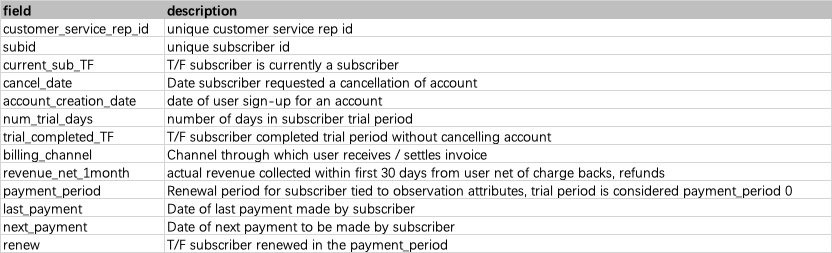


In [0]:
service

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248409,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,3,2019-08-27 20:23:27,2019-09-24 20:23:29,NaN
2248410,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,4,2019-09-24 20:23:29,2019-10-25 20:23:28,NaN
2248411,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,5,2019-10-25 20:23:28,2019-11-24 20:23:29,NaN
2248412,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,6,2019-11-24 20:23:29,2019-12-25 20:23:27,NaN


In [0]:
service.loc[service['subid']==29999945]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
85553,39121936,29999945,True,NaT,2020-03-14 03:04:55,14,True,OTT,4.5875,0,2020-03-14 06:43:29,2020-03-28 14:07:13,True
85554,39121936,29999945,True,NaT,2020-03-14 03:04:55,14,True,OTT,4.5875,1,2020-03-28 14:07:13,NaT,False


In [0]:
service.loc[(service['num_trial_days']==7)&(service['renew'].isnull()==True)&(service['payment_period']==0)]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
786,34814570,27350108,True,NaT,2020-03-27 22:01:46,7,True,itunes,1.1377,0,2020-03-27 22:01:46,2020-04-03 22:01:46,NaN
1381,34040651,21149617,False,NaT,2020-03-27 20:12:53,7,True,itunes,0.0000,0,2020-03-27 20:12:53,NaT,NaN
1465,34040651,23260912,False,NaT,2020-03-27 20:00:37,7,True,itunes,0.0000,0,2020-03-27 20:00:37,NaT,NaN
1556,34601511,28313240,True,NaT,2020-03-27 19:48:22,7,True,itunes,1.1377,0,2020-03-27 19:48:22,2020-04-03 19:48:21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248081,37138794,21641841,False,NaT,2019-06-30 00:13:30,7,True,itunes,0.0000,0,2019-06-30 00:13:30,NaT,NaN
2248131,31236268,22763714,False,NaT,2019-06-30 00:10:58,7,True,itunes,1.1377,0,2019-06-30 00:10:58,2019-07-07 00:10:57,NaN
2248209,32291974,26847987,False,NaT,2019-06-30 00:08:21,7,True,itunes,0.0000,0,2019-06-30 00:08:21,NaT,NaN
2248280,38865556,22540411,False,NaT,2019-06-30 00:05:19,7,True,itunes,1.1377,0,2019-06-30 00:05:19,2019-07-07 00:05:19,NaN


In [0]:
service.loc[(service['payment_period']==0)].groupby(['num_trial_days'])['account_creation_date'].max()

num_trial_days
0    2020-03-28 00:00:00
7    2020-03-27 22:01:46
14   2020-03-27 23:59:39
Name: account_creation_date, dtype: datetime64[ns]

In [0]:
service.loc[service['renew'].isnull()==False]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew,duration
60,33513851,28948735,False,2020-04-06 19:21:05,2020-03-27 23:59:39,14,False,OTT,0.0000,0,2020-03-27 23:59:39,NaT,False,NaT
61,30034436,21697364,False,2020-04-08 13:16:39,2020-03-27 23:59:06,14,False,OTT,0.0000,0,2020-03-28 00:05:20,NaT,False,NaT
62,31856201,27800927,True,NaT,2020-03-27 23:59:04,14,True,OTT,4.5875,0,2020-03-28 00:05:20,2020-04-11 11:05:24,True,14 days 11:00:04
63,31856201,27800927,True,NaT,2020-03-27 23:59:04,14,True,OTT,4.5875,1,2020-04-11 11:05:24,NaT,False,NaT
67,34138852,20407871,False,2020-04-01 05:42:28,2020-03-27 23:58:49,14,False,OTT,0.0000,0,2020-03-27 23:58:49,NaT,False,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248391,30967722,24792193,True,NaT,2019-06-30 00:01:11,14,True,OTT,4.7343,3,2020-03-13 19:27:38,NaT,False,NaT
2248394,30947283,26986758,False,2019-07-12 23:23:24,2019-06-30 00:00:51,14,False,OTT,0.0000,0,2019-06-30 01:05:29,NaT,False,NaT
2248395,39561825,22320767,False,2019-11-27 09:30:04,2019-06-30 00:00:34,14,True,OTT,4.5875,0,2019-06-30 00:00:34,2019-07-14 10:43:57,True,14 days 10:43:23
2248396,39561825,22320767,False,2019-11-27 09:30:04,2019-06-30 00:00:34,14,True,OTT,4.5875,1,2019-07-14 10:43:57,NaT,False,NaT


In [0]:
service['duration'] = service['next_payment'] - service['last_payment']

In [0]:
service.loc[(service['renew'].isnull()==True)&(service['payment_period']!=0)].groupby(['subid'])['duration'].max().mean()

Timedelta('80 days 21:41:31.659636')

In [0]:
service.loc[(service['renew'].isnull()==False)&(service['payment_period']!=0)].groupby(['subid'])['duration'].max().mean()

Timedelta('122 days 00:31:59.131096')

In [0]:
service.loc[service['subid']==26845271]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
2248406,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,0,2019-06-30 06:24:24,2019-06-29 20:24:28,NaN
2248407,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,1,2019-06-29 20:24:28,2019-07-30 20:23:27,NaN
2248408,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,2,2019-07-30 20:23:27,2019-08-27 20:23:27,NaN
2248409,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,3,2019-08-27 20:23:27,2019-09-24 20:23:29,NaN
2248410,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,4,2019-09-24 20:23:29,2019-10-25 20:23:28,NaN
2248411,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,5,2019-10-25 20:23:28,2019-11-24 20:23:29,NaN
2248412,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,6,2019-11-24 20:23:29,2019-12-25 20:23:27,NaN
2248413,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,7,2019-12-25 20:23:27,NaT,NaN


In [0]:
service.loc[service['subid']==25108574]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN


In [0]:
service.describe(include='all')

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
count,2.208643e+06,2.208643e+06,2208643,854562,2208643,2.208643e+06,2208643,2208643,2.208643e+06,2.208643e+06,2208643,839283,606247
unique,NaN,NaN,2,758040,1303669,NaN,2,3,NaN,NaN,736390,228115,2
top,NaN,NaN,False,2020-03-30 14:42:00,2020-02-13 00:00:00,NaN,True,OTT,NaN,NaN,2020-03-14 14:01:21,2020-03-28 14:07:13,False
freq,NaN,NaN,1390355,9,112,NaN,1547704,1848663,NaN,NaN,3969,3755,387666
first,NaN,NaN,NaN,2019-06-30 00:25:07,2019-06-30 00:00:04,NaN,NaN,NaN,NaN,NaN,2019-06-29 20:24:28,2019-06-29 20:24:28,NaN
last,NaN,NaN,NaN,2020-04-22 05:50:07,2020-03-28 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-04-22 14:04:58,2020-04-22 14:04:58,NaN
mean,3.504146e+07,2.499531e+07,NaN,NaN,NaN,1.298418e+01,NaN,NaN,2.248010e+00,5.850402e-01,NaN,NaN,NaN
std,2.808791e+06,2.887118e+06,NaN,NaN,NaN,3.102689e+00,NaN,NaN,2.222221e+00,1.003588e+00,NaN,NaN,NaN
min,3.000466e+07,2.000000e+07,NaN,NaN,NaN,0.000000e+00,NaN,NaN,-7.596900e+00,0.000000e+00,NaN,NaN,NaN
25%,3.273768e+07,2.249642e+07,NaN,NaN,NaN,1.400000e+01,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN


# AB Test

## Merge for AB_test


In [0]:
subscribers['subid'].nunique()

227628

In [0]:
engagement['subid'].nunique()

135019

In [0]:
mean_sum['subid'].nunique()

135019

In [0]:
service['subid'].nunique()

1369360

In [0]:
eng_ser = pd.merge(service,mean_sum,on=['subid','payment_period'], how='right')

In [0]:
eng_ser

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew,duration,"(app_opens, mean)","(app_opens, sum)","(cust_service_mssgs, mean)","(cust_service_mssgs, sum)","(num_videos_completed, mean)","(num_videos_completed, sum)","(num_videos_more_than_30_seconds, mean)","(num_videos_more_than_30_seconds, sum)","(num_videos_rated, mean)","(num_videos_rated, sum)","(num_series_started, mean)","(num_series_started, sum)"
0,30034436,21697364,False,2020-04-08 13:16:39,2020-03-27 23:59:06,14,False,OTT,0.0000,0,2020-03-28 00:05:20,NaT,False,NaT,1.200000,6.0,1.000000,5.0,0.600000,3.0,6.800000,34.0,0.000000,0.0,0.000000,0.0
1,34138852,20407871,False,2020-04-01 05:42:28,2020-03-27 23:58:49,14,False,OTT,0.0000,0,2020-03-27 23:58:49,NaT,False,NaT,0.833333,5.0,0.333333,2.0,3.166667,19.0,4.666667,28.0,0.000000,0.0,0.833333,5.0
2,33808892,27818002,False,2020-04-08 22:00:59,2020-03-27 23:53:40,14,False,OTT,0.0000,0,2020-03-28 00:05:20,NaT,False,NaT,4.692308,61.0,1.076923,14.0,4.846154,63.0,4.846154,63.0,0.000000,0.0,1.000000,13.0
3,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,14 days 07:12:43,5.933333,89.0,0.533333,8.0,4.600000,69.0,4.933333,74.0,0.000000,0.0,0.866667,13.0
4,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,1,2020-04-11 14:22:46,NaT,False,NaT,6.266667,94.0,0.400000,6.0,4.333333,65.0,4.466667,67.0,0.000000,0.0,0.733333,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202443,34410719,29969407,False,2019-07-07 14:15:50,2019-06-30 00:01:31,14,False,OTT,0.0000,0,2019-06-30 01:05:36,NaT,False,NaT,1.000000,8.0,1.125000,9.0,3.750000,30.0,4.875000,39.0,0.000000,0.0,0.875000,7.0
202444,38865556,27585257,False,NaT,2019-06-30 00:01:25,14,True,OTT,4.9178,0,2019-06-30 00:01:25,2019-07-14 14:33:09,True,14 days 14:31:44,1.066667,16.0,0.600000,9.0,4.666667,70.0,4.800000,72.0,0.066667,1.0,1.000000,15.0
202445,38865556,27585257,False,NaT,2019-06-30 00:01:25,14,True,OTT,4.9178,1,2019-07-14 14:33:09,NaT,False,NaT,1.000000,31.0,0.548387,17.0,3.967742,123.0,4.225806,131.0,0.161290,5.0,0.870968,27.0
202446,30947283,26986758,False,2019-07-12 23:23:24,2019-06-30 00:00:51,14,False,OTT,0.0000,0,2019-06-30 01:05:29,NaT,False,NaT,0.846154,11.0,0.384615,5.0,3.307692,43.0,4.692308,61.0,0.000000,0.0,0.769231,10.0


In [0]:
eng_ser.loc[eng_ser['num_trial_days']!=14]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew,duration,"(app_opens, mean)","(app_opens, sum)","(cust_service_mssgs, mean)","(cust_service_mssgs, sum)","(num_videos_completed, mean)","(num_videos_completed, sum)","(num_videos_more_than_30_seconds, mean)","(num_videos_more_than_30_seconds, sum)","(num_videos_rated, mean)","(num_videos_rated, sum)","(num_series_started, mean)","(num_series_started, sum)"
6855,31591685,26987319,True,NaT,2020-03-14 06:16:13,0,True,OTT,4.5875,1,2020-03-14 07:05:25,2020-03-14 07:05:25,False,0 days 00:00:00,0.800000,8.0,0.500000,5.0,4.300000,43.0,4.700000,47.0,0.000000,0.0,0.200000,2.0
166255,37938390,22335663,False,2020-04-13 10:00:44,2019-07-28 15:00:23,0,True,OTT,1.0276,1,2019-07-30 10:30:43,2019-11-27 13:38:27,True,120 days 03:07:44,0.840000,21.0,0.080000,2.0,1.680000,42.0,4.200000,105.0,0.000000,0.0,0.440000,11.0
166292,37297757,21395906,False,NaT,2019-07-28 12:58:40,0,True,OTT,1.0276,1,2019-08-07 11:06:00,2019-12-05 11:05:18,True,119 days 23:59:18,2.129032,66.0,0.129032,4.0,0.903226,28.0,4.322581,134.0,0.032258,1.0,0.258065,8.0
166293,37297757,21395906,False,NaT,2019-07-28 12:58:40,0,True,OTT,1.0276,2,2019-12-05 11:05:18,NaT,False,NaT,1.352941,23.0,0.058824,1.0,0.000000,0.0,3.764706,64.0,0.000000,0.0,0.058824,1.0
166409,38516836,27542549,False,NaT,2019-07-28 02:39:26,0,True,OTT,1.0276,1,2019-07-29 14:36:03,2019-11-26 13:39:52,True,119 days 23:03:49,1.612903,50.0,0.129032,4.0,4.193548,130.0,4.322581,134.0,0.322581,10.0,0.967742,30.0
166410,38516836,27542549,False,NaT,2019-07-28 02:39:26,0,True,OTT,1.0276,2,2019-11-26 13:39:52,NaT,False,NaT,1.766667,53.0,0.100000,3.0,3.633333,109.0,4.000000,120.0,0.133333,4.0,0.766667,23.0
166607,32080209,28496166,True,NaT,2019-07-27 19:57:50,0,True,OTT,1.0276,1,2019-08-10 11:05:32,2019-12-08 10:05:17,True,119 days 22:59:45,2.451613,76.0,0.354839,11.0,4.064516,126.0,4.580645,142.0,0.064516,2.0,1.000000,31.0
166608,32080209,28496166,True,NaT,2019-07-27 19:57:50,0,True,OTT,1.0276,2,2019-12-08 10:05:17,2020-04-08 10:05:30,True,122 days 00:00:13,2.620690,76.0,0.310345,9.0,2.068966,60.0,4.172414,121.0,0.000000,0.0,0.620690,18.0
166609,32080209,28496166,True,NaT,2019-07-27 19:57:50,0,True,OTT,1.0276,3,2020-04-08 10:05:30,NaT,False,NaT,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
166622,33403934,24742837,True,NaT,2019-07-27 19:18:55,0,True,OTT,1.0276,1,2019-07-29 11:05:45,2019-11-26 11:05:18,True,119 days 23:59:33,0.695652,16.0,0.043478,1.0,1.826087,42.0,4.478261,103.0,0.000000,0.0,0.434783,10.0


In [0]:
eng_ser.loc[(eng_ser['cancel_date'].isnull()==True)&(eng_ser['renew'].isnull()==False)]

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew,duration,"(app_opens, mean)","(app_opens, sum)","(cust_service_mssgs, mean)","(cust_service_mssgs, sum)","(num_videos_completed, mean)","(num_videos_completed, sum)","(num_videos_more_than_30_seconds, mean)","(num_videos_more_than_30_seconds, sum)","(num_videos_rated, mean)","(num_videos_rated, sum)","(num_series_started, mean)","(num_series_started, sum)"
3,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,14 days 07:12:43,5.933333,89.0,0.533333,8.0,4.600000,69.0,4.933333,74.0,0.000000,0.0,0.866667,13.0
4,34413500,23796492,True,NaT,2020-03-27 23:52:29,14,True,OTT,4.5875,1,2020-04-11 14:22:46,NaT,False,NaT,6.266667,94.0,0.400000,6.0,4.333333,65.0,4.466667,67.0,0.000000,0.0,0.733333,11.0
5,31714601,20162910,True,NaT,2020-03-27 23:51:37,14,True,OTT,4.5875,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,14 days 07:12:43,0.909091,10.0,0.272727,3.0,3.272727,36.0,4.636364,51.0,0.000000,0.0,0.454545,5.0
6,31714601,20162910,True,NaT,2020-03-27 23:51:37,14,True,OTT,4.5875,1,2020-04-11 14:22:46,NaT,False,NaT,1.000000,4.0,0.000000,0.0,0.000000,0.0,2.500000,10.0,0.000000,0.0,0.000000,0.0
9,33630522,22120282,True,NaT,2020-03-27 23:47:11,14,True,OTT,4.8811,0,2020-03-28 07:10:03,2020-04-11 14:22:46,True,14 days 07:12:43,0.555556,5.0,0.444444,4.0,0.777778,7.0,4.222222,38.0,0.000000,0.0,0.111111,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202440,30967722,26531005,True,NaT,2019-06-30 00:01:45,14,True,OTT,3.4498,1,2019-07-14 11:06:54,2019-11-11 11:05:20,True,119 days 23:58:26,1.870968,58.0,0.258065,8.0,1.258065,39.0,3.741935,116.0,0.032258,1.0,0.774194,24.0
202441,30967722,26531005,True,NaT,2019-06-30 00:01:45,14,True,OTT,3.4498,2,2019-11-11 11:05:20,2020-03-13 11:05:22,True,123 days 00:00:02,1.730769,45.0,0.115385,3.0,0.384615,10.0,3.269231,85.0,0.000000,0.0,0.384615,10.0
202442,30967722,26531005,True,NaT,2019-06-30 00:01:45,14,True,OTT,3.4498,3,2020-03-13 11:05:22,NaT,False,NaT,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
202444,38865556,27585257,False,NaT,2019-06-30 00:01:25,14,True,OTT,4.9178,0,2019-06-30 00:01:25,2019-07-14 14:33:09,True,14 days 14:31:44,1.066667,16.0,0.600000,9.0,4.666667,70.0,4.800000,72.0,0.066667,1.0,1.000000,15.0


In [0]:
eng_ser.groupby(['payment_period','renew']).mean()

customer_service_rep_id  ...  (num_series_started, sum)
payment_period renew                           ...                           
0              False             3.505341e+07  ...                   3.085203
               True              3.505139e+07  ...                   9.081378
1              False             3.504138e+07  ...                  13.839277
               True              3.509452e+07  ...                  18.232249
2              False             3.510602e+07  ...                  15.096784
               True              3.508748e+07  ...                  15.976823
3              False             3.513269e+07  ...                   0.050124

[7 rows x 18 columns]

In [0]:
eng_ser['billing_channel'].value_counts()

OTT    202448
Name: billing_channel, dtype: int64

## Test Statistic


In [0]:
# compare the conversion rate of those who have 7-day trial and 14-day trial
# converted if they have renewed in trial period, which means they have continued to period 1
n1 = service.loc[(service['num_trial_days']==7),'subid'].nunique()
n2 = service.loc[(service['num_trial_days']==14),'subid'].nunique()
n1_converted = service.loc[(service['num_trial_days']==7)&(service['payment_period']==1),'subid'].nunique()
n2_converted = service.loc[(service['num_trial_days']==14)&(service['payment_period']==1),'subid'].nunique()
print('The number of people who have 7-day trial is: ' + str(n1))
print('The number of people who have 7-day trial and converted is: ' + str(n1_converted))
print('The number of people who have 14-day trial is: ' + str(n2))
print('The number of people who have 14-day trial and converted is: ' + str(n2_converted))


The number of people who have 7-day trial is: 64043
The number of people who have 7-day trial and converted is: 35314
The number of people who have 14-day trial is: 1281127
The number of people who have 14-day trial and converted is: 523596


In [0]:
p1 = n1_converted / n1
p2 = n2_converted / n2
print(p1)
print(p2)

0.5514107708883094
0.4086995278375992


In [0]:
std = math.sqrt(((p1 * (1-p1))/n1) + ((p2 * (1-p2))/n2))
z = (p1 - p2)/std
print(z)

70.90511117706859


In [0]:
# calculate p_value associated with the calculated z score -- under one-tailed test situation
result = (1 - stats.norm(0,1).cdf(z))
print ('P-value is ' + str(result))

P-value is 0.0


# Advertising channel spend efficiency

In [26]:
advertising = pd.read_excel('advertising_spend_data.xlsx',header=2)
advertising

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019-06-30,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07-31,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08-31,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09-30,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10-31,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11-30,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12-31,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01-31,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02-29,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03-31,49100,78000,22700,21200,17600,300,5900,10000


In [27]:
advertising.sum()

facebook                   552700
email                      760600
search                     232500
brand sem intent google    216100
affiliate                  139500
email_blast                226400
pinterest                   63300
referral                    73400
dtype: int64

In [0]:
advertising.set_index(keys='date',drop=True,inplace=True)

In [0]:
subscribers_1 = subscribers.resample('M',on='account_creation_date').attribution_technical.apply(pd.value_counts).unstack()

In [129]:
subscribers_1

,affiliate,appstore,bing,bing_organic,brand sem intent bing,brand sem intent google,content_greatist,criteo,direct_mail,discovery,display,email,email_blast,facebook,facebook_organic,google_organic,influencer,internal,organic,other,ott,pinterest,pinterest_organic,playstore,podcast,quora,referral,samsung,search,tv,twitter,vod,youtube
account_creation_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-06-30,78.0,NaN,7.0,2.0,40.0,197.0,NaN,NaN,NaN,NaN,3.0,309.0,109.0,1318.0,33.0,131.0,1.0,32.0,219.0,14.0,NaN,37.0,NaN,NaN,NaN,NaN,22.0,2.0,108.0,NaN,NaN,NaN,1.0
2019-07-31,839.0,NaN,120.0,45.0,231.0,2090.0,NaN,14.0,NaN,NaN,44.0,3260.0,1510.0,10011.0,328.0,1312.0,NaN,271.0,2640.0,211.0,NaN,793.0,5.0,NaN,33.0,NaN,528.0,82.0,1328.0,NaN,5.0,NaN,8.0
2019-08-31,1903.0,NaN,71.0,39.0,158.0,1895.0,2.0,18.0,NaN,265.0,74.0,3092.0,1902.0,9855.0,318.0,680.0,NaN,187.0,1658.0,152.0,NaN,637.0,2.0,NaN,49.0,NaN,521.0,2.0,1939.0,NaN,NaN,NaN,15.0
2019-09-30,1065.0,NaN,84.0,33.0,120.0,1530.0,NaN,10.0,NaN,688.0,12.0,2420.0,1582.0,6129.0,979.0,730.0,4.0,101.0,1418.0,200.0,NaN,517.0,1.0,NaN,54.0,77.0,582.0,NaN,1852.0,NaN,NaN,NaN,2.0
2019-10-31,760.0,NaN,86.0,29.0,130.0,1602.0,1.0,2.0,7.0,400.0,50.0,2305.0,977.0,9489.0,261.0,921.0,NaN,138.0,1466.0,129.0,NaN,682.0,4.0,NaN,84.0,12.0,529.0,NaN,2333.0,NaN,NaN,4.0,11.0
2019-11-30,509.0,NaN,103.0,27.0,255.0,2030.0,NaN,NaN,41.0,503.0,90.0,2584.0,629.0,12995.0,359.0,930.0,7.0,87.0,1640.0,164.0,12.0,594.0,2.0,NaN,81.0,11.0,587.0,NaN,2510.0,4.0,NaN,27.0,47.0
2019-12-31,565.0,3.0,28.0,38.0,126.0,2443.0,NaN,NaN,3.0,341.0,112.0,2677.0,411.0,9288.0,254.0,890.0,1.0,124.0,2377.0,152.0,6.0,851.0,6.0,NaN,94.0,NaN,666.0,NaN,3770.0,NaN,NaN,37.0,76.0
2020-01-31,1074.0,13.0,172.0,37.0,360.0,2626.0,1.0,NaN,64.0,233.0,536.0,2368.0,35.0,6289.0,245.0,1275.0,2.0,52.0,3050.0,263.0,36.0,819.0,4.0,4.0,198.0,NaN,584.0,NaN,4073.0,NaN,NaN,60.0,370.0
2020-02-29,1480.0,10.0,303.0,23.0,483.0,2346.0,NaN,NaN,22.0,91.0,341.0,3168.0,66.0,7988.0,280.0,1593.0,3.0,63.0,3419.0,239.0,69.0,680.0,3.0,6.0,228.0,NaN,583.0,NaN,4300.0,NaN,NaN,97.0,205.0


In [130]:
set(advertising.columns).difference(set(subscribers_1.columns))

set()

In [131]:
subscribers_1[advertising.columns].sum()

facebook                   80251.0
email                      25690.0
search                     25306.0
brand sem intent google    18524.0
affiliate                   9894.0
email_blast                 7277.0
pinterest                   6065.0
referral                    5170.0
dtype: float64

In [132]:
advertising

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
date,,,,,,,,
2019-06-30,84800,75000,17300,21400,11900,10500,5900,6100
2019-07-31,60000,75600,17300,21300,12000,29800,6000,6600
2019-08-31,52300,76100,18100,21300,16300,65900,6200,6800
2019-09-30,49000,75800,18900,21300,16400,73700,6000,7400
2019-10-31,51300,76000,21000,21400,12200,32300,6700,7300
2019-11-30,56100,75900,21400,21600,11700,9800,6300,7300
2019-12-31,51400,76100,32100,22200,12100,3500,7200,8000
2020-01-31,49000,75500,33600,22700,14300,300,6700,7400
2020-02-29,49700,76600,30100,21700,15000,300,6400,6500


In [156]:
subscribers_1[advertising.columns]

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
account_creation_date,,,,,,,,
2019-06-30,1318.0,309.0,108.0,197.0,78.0,109.0,37.0,22.0
2019-07-31,10011.0,3260.0,1328.0,2090.0,839.0,1510.0,793.0,528.0
2019-08-31,9855.0,3092.0,1939.0,1895.0,1903.0,1902.0,637.0,521.0
2019-09-30,6129.0,2420.0,1852.0,1530.0,1065.0,1582.0,517.0,582.0
2019-10-31,9489.0,2305.0,2333.0,1602.0,760.0,977.0,682.0,529.0
2019-11-30,12995.0,2584.0,2510.0,2030.0,509.0,629.0,594.0,587.0
2019-12-31,9288.0,2677.0,3770.0,2443.0,565.0,411.0,851.0,666.0
2020-01-31,6289.0,2368.0,4073.0,2626.0,1074.0,35.0,819.0,584.0
2020-02-29,7988.0,3168.0,4300.0,2346.0,1480.0,66.0,680.0,583.0


In [133]:
CAC = advertising/subscribers_1[advertising.columns]
CAC

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
date,,,,,,,,
2019-06-30,64.339909,242.718447,160.185185,108.629442,152.564103,96.330275,159.459459,277.272727
2019-07-31,5.993407,23.190184,13.027108,10.191388,14.302741,19.735099,7.566204,12.500000
2019-08-31,5.306951,24.611902,9.334709,11.240106,8.565423,34.647739,9.733124,13.051823
2019-09-30,7.994779,31.322314,10.205184,13.921569,15.399061,46.586599,11.605416,12.714777
2019-10-31,5.406260,32.971800,9.001286,13.358302,16.052632,33.060389,9.824047,13.799622
2019-11-30,4.317045,29.373065,8.525896,10.640394,22.986248,15.580286,10.606061,12.436116
2019-12-31,5.534022,28.427344,8.514589,9.087188,21.415929,8.515815,8.460635,12.012012
2020-01-31,7.791382,31.883446,8.249448,8.644326,13.314711,8.571429,8.180708,12.671233
2020-02-29,6.221833,24.179293,7.000000,9.249787,10.135135,4.545455,9.411765,11.149228


In [0]:
CAC.to_csv("CAC.csv")

# Churn Model


## Merge and Feature Selection


In [0]:
eng_whole = pd.read_csv('eng_whole.csv',index_col=0)

In [0]:
eng_whole

,subid,newest_period,current_user,payment_period,active_days,duration,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,pass_0,converted_on_0,pass_1,converted_on_1,pass_2,converted_on_2,churn
0,20000604,1.0,0,1.0,2,11,1.0,1.0,0.0,4.0,0.0,0.0,True,True,False,False,False,False,1.0
1,20000685,1.0,0,1.0,25,29,29.0,6.0,3.0,102.0,0.0,1.0,True,True,False,False,False,False,1.0
2,20000796,1.0,0,1.0,31,31,144.0,10.0,127.0,131.0,2.0,28.0,True,True,False,False,False,False,1.0
3,20001112,1.0,0,1.0,21,30,11.0,1.0,1.0,77.0,0.0,13.0,True,True,False,False,False,False,1.0
4,20001132,1.0,0,1.0,31,31,30.0,12.0,87.0,132.0,6.0,8.0,True,True,False,False,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53713,29995579,1.0,1,1.0,2,9,2.0,0.0,0.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53714,29997578,1.0,1,1.0,30,30,31.0,19.0,114.0,128.0,15.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53715,29998441,1.0,1,1.0,2,7,2.0,0.0,0.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53716,29998629,1.0,1,1.0,1,1,2.0,3.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
eng_whole.columns

Index(['subid', 'newest_period', 'current_user', 'payment_period',
       'active_days', 'duration', 'app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started', 'pass_0', 'converted_on_0',
       'pass_1', 'converted_on_1', 'pass_2', 'converted_on_2', 'churn'],
      dtype='object')

In [0]:
eng_whole.drop(columns=['newest_period','payment_period','current_user','pass_0', 'converted_on_0',
       'pass_1', 'converted_on_1', 'pass_2', 'converted_on_2'],inplace=True)

In [0]:
eng_whole['active_percentage'] = eng_whole['active_days'] / eng_whole['duration'] 
eng_whole['app_opens'] = eng_whole['app_opens'] / eng_whole['active_days'] 
eng_whole['cust_service_mssgs'] = eng_whole['cust_service_mssgs'] / eng_whole['active_days'] 
eng_whole['num_videos_completed'] = eng_whole['num_videos_completed'] / eng_whole['active_days'] 
eng_whole['num_videos_more_than_30_seconds'] = eng_whole['num_videos_more_than_30_seconds'] / eng_whole['active_days'] 
eng_whole['num_videos_rated'] = eng_whole['num_videos_rated'] / eng_whole['active_days'] 
eng_whole['num_series_started'] = eng_whole['num_series_started'] / eng_whole['active_days'] 

In [0]:
eng_whole.drop(columns=['active_days','duration'],inplace=True)

In [0]:
eng_whole

,subid,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,churn,active_percentage
0,20000604,0.500000,0.500000,0.000000,2.000000,0.000000,0.000000,1.0,0.181818
1,20000685,1.160000,0.240000,0.120000,4.080000,0.000000,0.040000,1.0,0.862069
2,20000796,4.645161,0.322581,4.096774,4.225806,0.064516,0.903226,1.0,1.000000
3,20001112,0.523810,0.047619,0.047619,3.666667,0.000000,0.619048,1.0,0.700000
4,20001132,0.967742,0.387097,2.806452,4.258065,0.193548,0.258065,1.0,1.000000
...,...,...,...,...,...,...,...,...,...
53713,29995579,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,NaN,0.222222
53714,29997578,1.033333,0.633333,3.800000,4.266667,0.500000,0.966667,NaN,1.000000
53715,29998441,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,NaN,0.285714
53716,29998629,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,NaN,1.000000


In [0]:
subscribers.columns

Index(['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type'],
      dtype='object')

In [0]:
subscribers.drop(columns=['num_weekly_services_utilized',
        'weekly_consumption_hour','num_ideal_streaming_services', 'retarget_TF', 
       'country', 'attribution_technical', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type'],inplace=True)

In [0]:
subscribers

,subid,package_type,preferred_genre,intended_use,age,male_TF,attribution_survey
162502,21724479,economy,comedy,access to exclusive content,NaN,False,facebook
380374,23383224,base,comedy,access to exclusive content,70.0,False,facebook
496617,26844789,enhanced,regional,replace OTT,25.0,True,facebook
356799,29417030,base,drama,replace OTT,30.0,False,tv
681701,26723159,base,comedy,replace OTT,28.0,False,youtube
...,...,...,...,...,...,...,...
509326,21434712,enhanced,comedy,supplement OTT,38.0,False,facebook_organic
229587,25843074,enhanced,comedy,replace OTT,49.0,False,referral
281340,24799085,base,comedy,access to exclusive content,45.0,False,facebook
87198,21308040,base,comedy,access to exclusive content,NaN,False,facebook


In [0]:
eng_sub = pd.merge(subscribers,eng_whole,on=['subid'], how='right')

In [0]:
eng_sub

,subid,package_type,preferred_genre,intended_use,age,male_TF,attribution_survey,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,churn,active_percentage
0,29726122,base,comedy,access to exclusive content,61.0,False,search,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.0,1.000000
1,20299962,base,drama,access to exclusive content,23.0,False,referral,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.0,1.000000
2,21511732,enhanced,comedy,replace OTT,26.0,False,referral,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,1.0,0.555556
3,29576692,NaN,NaN,expand international access,31.0,False,facebook,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.0,1.000000
4,29773460,base,comedy,access to exclusive content,NaN,False,facebook,4.000000,0.043478,0.956522,4.347826,0.000000,0.173913,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53713,25927672,NaN,NaN,expand regional access,34.0,False,tv,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.0,1.000000
53714,29190645,enhanced,comedy,access to exclusive content,46.0,False,social_organic,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,1.0,0.967742
53715,28920930,enhanced,regional,replace OTT,NaN,False,facebook,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.0,0.967742
53716,21928274,base,drama,replace OTT,NaN,False,facebook,1.692308,0.538462,2.230769,6.153846,0.076923,0.692308,1.0,1.000000


In [0]:
eng_sub.describe(include="all")

,subid,package_type,preferred_genre,intended_use,age,male_TF,attribution_survey,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,churn,active_percentage
count,5.371800e+04,43211,43103,52818,32235.000000,53718,52983,53718.000000,53718.000000,53718.000000,53718.000000,53718.000000,53718.000000,49620.000000,53718.000000
unique,NaN,3,5,7,NaN,2,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,base,comedy,access to exclusive content,NaN,False,facebook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,26214,28353,21333,NaN,47347,26949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.499088e+07,NaN,NaN,NaN,47.623071,NaN,NaN,1.980309,0.330673,1.832036,4.012839,0.080867,0.551640,0.759331,0.852971
std,2.891564e+06,NaN,NaN,NaN,13.166179,NaN,NaN,1.729494,0.530314,1.650117,0.920739,0.173090,0.393082,0.427494,0.230094
min,2.000060e+07,NaN,NaN,NaN,18.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064516
25%,2.247917e+07,NaN,NaN,NaN,38.000000,NaN,NaN,1.000000,0.083333,0.052632,4.000000,0.000000,0.090909,1.000000,0.774194
50%,2.498348e+07,NaN,NaN,NaN,48.000000,NaN,NaN,1.333333,0.225806,1.500000,4.258065,0.000000,0.653846,1.000000,1.000000
75%,2.750343e+07,NaN,NaN,NaN,57.000000,NaN,NaN,2.451613,0.400000,3.612903,4.296296,0.086957,0.935484,1.000000,1.000000


In [0]:
eng_sub.isnull().sum()

subid                                  0
package_type                       10507
preferred_genre                    10615
intended_use                         900
age                                21483
male_TF                                0
attribution_survey                   735
app_opens                              0
cust_service_mssgs                     0
num_videos_completed                   0
num_videos_more_than_30_seconds        0
num_videos_rated                       0
num_series_started                     0
churn                               4098
active_percentage                      0
dtype: int64

In [0]:
eng_sub['package_type'].value_counts()

base        26214
enhanced    12963
economy      4034
Name: package_type, dtype: int64

In [0]:
eng_sub.groupby(['churn','package_type'])['app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started','active_percentage'].mean()

app_opens  ...  active_percentage
churn package_type             ...                   
0.0   base           2.400591  ...           0.914163
      economy        2.481613  ...           0.922262
      enhanced       2.277076  ...           0.874009
1.0   base           1.974429  ...           0.843346
      economy        1.992240  ...           0.852886
      enhanced       1.855853  ...           0.815765

[6 rows x 7 columns]

In [0]:
eng_sub['preferred_genre'].value_counts()

comedy           28353
drama            10107
regional          2224
international     1394
other             1025
Name: preferred_genre, dtype: int64

In [12]:
eng_sub.groupby(['preferred_genre'])['churn','app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started','active_percentage'].mean()

,churn,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage
preferred_genre,,,,,,,,
comedy,0.795020,2.064344,0.331556,1.829873,4.022670,0.077057,0.551895,0.852092
drama,0.797496,1.949972,0.342931,1.765900,4.033229,0.077957,0.533547,0.843012
international,0.767645,1.864950,0.328328,1.769051,4.072874,0.097245,0.543365,0.846771
other,0.772632,2.111271,0.362506,2.108561,4.051927,0.111892,0.599591,0.878807
regional,0.794190,1.972119,0.302842,1.650080,3.952962,0.070971,0.528648,0.835761


In [0]:
eng_sub['intended_use'].value_counts()

access to exclusive content    21333
replace OTT                    14884
supplement OTT                  5584
expand regional access          4364
expand international access     3693
other                           1488
education                       1472
Name: intended_use, dtype: int64

In [13]:
eng_sub.groupby(['intended_use'])['churn','app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started','active_percentage'].mean()

,churn,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage
intended_use,,,,,,,,
access to exclusive content,0.795860,2.051270,0.328849,1.883532,4.041955,0.082406,0.561014,0.852542
education,0.650136,1.700733,0.331873,1.781068,3.961340,0.083934,0.539775,0.858915
expand international access,0.624323,1.785351,0.328569,1.875469,3.942944,0.083962,0.559217,0.863386
expand regional access,0.602891,1.782779,0.307995,1.998192,3.978017,0.098615,0.583609,0.869347
other,0.750725,2.024401,0.390312,1.976972,4.019627,0.124731,0.564625,0.868521
replace OTT,0.793664,2.021520,0.331333,1.739258,4.003593,0.069854,0.533997,0.848109
supplement OTT,0.789831,1.934647,0.342775,1.696601,4.012391,0.076593,0.528165,0.839280


In [0]:
eng_sub.groupby(['churn','male_TF'])['app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started','active_percentage'].mean()

app_opens  ...  active_percentage
churn male_TF             ...                   
0.0   False     2.289997  ...           0.908797
      True      2.183489  ...           0.894140
1.0   False     1.896210  ...           0.837384
      True      1.788504  ...           0.827663

[4 rows x 7 columns]

In [0]:
eng_sub.loc[(eng_sub['churn']==1),'age'].value_counts(bins=5)

(46.4, 60.6]                  7916
(32.2, 46.4]                  6953
(17.927999999999997, 32.2]    3535
(60.6, 74.8]                  3517
(74.8, 89.0]                   256
Name: age, dtype: int64

In [0]:
eng_sub.loc[(eng_sub['churn']==0),'age'].value_counts(bins=5)

(44.8, 58.2]      3009
(31.4, 44.8]      2008
(58.2, 71.6]      1710
(17.932, 31.4]     755
(71.6, 85.0]       213
Name: age, dtype: int64

Leave only intended use information and gender difference

In [0]:
eng_sub.loc[(eng_sub['male_TF'] == False),'male_TF']= 0
eng_sub.loc[(eng_sub['male_TF'] == True),'male_TF']= 1

In [0]:
eng_sub

,subid,package_type,preferred_genre,intended_use,age,male_TF,attribution_survey,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,churn,active_percentage
0,29726122,base,comedy,access to exclusive content,61.0,0,search,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.0,1.000000
1,20299962,base,drama,access to exclusive content,23.0,0,referral,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.0,1.000000
2,21511732,enhanced,comedy,replace OTT,26.0,0,referral,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,1.0,0.555556
3,29576692,NaN,NaN,expand international access,31.0,0,facebook,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.0,1.000000
4,29773460,base,comedy,access to exclusive content,NaN,0,facebook,4.000000,0.043478,0.956522,4.347826,0.000000,0.173913,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53713,25927672,NaN,NaN,expand regional access,34.0,0,tv,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.0,1.000000
53714,29190645,enhanced,comedy,access to exclusive content,46.0,0,social_organic,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,1.0,0.967742
53715,28920930,enhanced,regional,replace OTT,NaN,0,facebook,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.0,0.967742
53716,21928274,base,drama,replace OTT,NaN,0,facebook,1.692308,0.538462,2.230769,6.153846,0.076923,0.692308,1.0,1.000000


In [0]:
# number of people: 20468 

def getOTT(intended_use):
  if (intended_use == 'replace OTT')|(intended_use == 'supplement OTT'):
    return 1
  else:
    return 0
  
eng_sub['OTT_usage'] = eng_sub['intended_use'].apply(getOTT)

In [0]:
# number of people: 9529

def getService(intended_use):
  if (intended_use == 'expand regional access')|(intended_use == 'expand international access')|(intended_use == 'education'):
    return 1
  else:
    return 0
  
eng_sub['expand_usage'] = eng_sub['intended_use'].apply(getService)

In [0]:
eng_sub.columns

Index(['subid', 'package_type', 'preferred_genre', 'intended_use', 'age',
       'male_TF', 'attribution_survey', 'app_opens', 'cust_service_mssgs',
       'num_videos_completed', 'num_videos_more_than_30_seconds',
       'num_videos_rated', 'num_series_started', 'churn', 'active_percentage',
       'OTT_usage', 'expand_usage'],
      dtype='object')

In [0]:
eng_sub.drop(columns=['package_type', 'preferred_genre', 'intended_use', 'age','attribution_survey'],inplace=True)

In [0]:
eng_sub.loc[(eng_sub['churn'] == 1),'renew']= 0
eng_sub.loc[(eng_sub['churn'] == 0),'renew']= 1
eng_sub.loc[(eng_sub['churn'].isnull() == True),'renew']= np.nan

In [0]:
eng_sub.drop(columns=['churn'],inplace=True)

In [0]:
eng_sub

,subid,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,renew
0,29726122,0,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.000000,0,0,0
1,20299962,0,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.000000,0,0,0
2,21511732,0,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,0.555556,1,0,0
3,29576692,0,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.000000,0,1,0
4,29773460,0,4.000000,0.043478,0.956522,4.347826,0.000000,0.173913,1.000000,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
53713,25927672,0,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.000000,0,1,0
53714,29190645,0,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,0.967742,0,0,0
53715,28920930,0,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.967742,1,0,1
53716,21928274,0,1.692308,0.538462,2.230769,6.153846,0.076923,0.692308,1.000000,1,0,0


In [0]:
eng_sub.to_csv("eng_sub.csv")

## Linear Regression



In [0]:
import statsmodels.api as sm # import statsmodels 
from statsmodels.compat import lzip
from statsmodels.formula.api import ols

In [0]:
eng_sub = pd.read_csv('eng_sub.csv',index_col=0)

In [0]:
eng_sub.set_index(keys = ['subid'],drop = True,inplace=True)

In [18]:
train_set = eng_sub.loc[eng_sub['renew'].isnull()==False]
train_set

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,renew
subid,,,,,,,,,,,
29726122,0,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.000000,0,0,0.0
20299962,0,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.000000,0,0,0.0
21511732,0,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,0.555556,1,0,0.0
29576692,0,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.000000,0,1,0.0
21447938,0,4.935484,0.645161,3.741935,4.258065,0.064516,0.967742,1.000000,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
25927672,0,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.000000,0,1,0.0
29190645,0,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,0.967742,0,0,0.0
28920930,0,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.967742,1,0,1.0


In [0]:
train_set['male_TF'] = train_set['male_TF'].astype('int')
train_set['churn'] = train_set['churn'].astype('int')

In [22]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49620 entries, 29726122 to 25843074
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   male_TF                          49620 non-null  int64  
 1   app_opens                        49620 non-null  float64
 2   cust_service_mssgs               49620 non-null  float64
 3   num_videos_completed             49620 non-null  float64
 4   num_videos_more_than_30_seconds  49620 non-null  float64
 5   num_videos_rated                 49620 non-null  float64
 6   num_series_started               49620 non-null  float64
 7   active_percentage                49620 non-null  float64
 8   OTT_usage                        49620 non-null  int64  
 9   expand_usage                     49620 non-null  int64  
 10  churn                            49620 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 4.5 MB


In [23]:
cols = list(train_set.columns)
cols.pop()
cols

['male_TF',
 'app_opens',
 'cust_service_mssgs',
 'num_videos_completed',
 'num_videos_more_than_30_seconds',
 'num_videos_rated',
 'num_series_started',
 'active_percentage',
 'OTT_usage',
 'expand_usage']

In [0]:
#cols.remove('OTT_usage')
#cols.remove('male_TF')
cols.remove('num_videos_more_than_30_seconds')

In [25]:
X = train_set[cols] ## X usually means our input variables (or independent variables)
y = train_set['churn'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y,X,missing='drop').fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     447.4
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        10:39:17   Log-Likelihood:                -26097.
No. Observations:               49620   AIC:                         5.222e+04
Df Residuals:                   49609   BIC:                         5.231e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

## Logistic Regression


In [0]:
eng_sub = pd.read_csv('eng_sub.csv',index_col=0)

In [0]:
eng_sub.set_index(keys = ['subid'],drop = True,inplace=True)

In [29]:
train_set = eng_sub.loc[eng_sub['renew'].isnull()==False]
train_set

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,renew
subid,,,,,,,,,,,
29726122,0,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.000000,0,0,0.0
20299962,0,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.000000,0,0,0.0
21511732,0,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,0.555556,1,0,0.0
29576692,0,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.000000,0,1,0.0
21447938,0,4.935484,0.645161,3.741935,4.258065,0.064516,0.967742,1.000000,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
25927672,0,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.000000,0,1,0.0
29190645,0,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,0.967742,0,0,0.0
28920930,0,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.967742,1,0,1.0


In [0]:
train_set.loc[(train_set['renew'] == 1),'churn']= 0
train_set.loc[(train_set['renew'] == 0),'churn']= 1

In [0]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49620 entries, 29726122 to 25843074
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   male_TF                          49620 non-null  int64  
 1   app_opens                        49620 non-null  float64
 2   cust_service_mssgs               49620 non-null  float64
 3   num_videos_completed             49620 non-null  float64
 4   num_videos_more_than_30_seconds  49620 non-null  float64
 5   num_videos_rated                 49620 non-null  float64
 6   num_series_started               49620 non-null  float64
 7   active_percentage                49620 non-null  float64
 8   OTT_usage                        49620 non-null  int64  
 9   expand_usage                     49620 non-null  int64  
 10  renew                            49620 non-null  float64
 11  churn                            49620 non-null  float64
dtypes: float

In [0]:
train_set.drop(columns=['renew'],inplace=True)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = train_set.drop(columns = ['churn'])
X_sca = scaler.fit_transform(X)

In [0]:
X = train_set.drop(columns = ['churn'])
y = train_set['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [58]:
N_FOLDS = 10
MAX_EVALS = 50

def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC

    clf = LogisticRegression(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf, X = X_train, y = y_train, cv=5, scoring='roc_auc')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    #'class_weight': hp.choice('class_weight', [None, class_weight]),
    #'penalty': hp.choice('penalty', ['l1', 'l2']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 50/50 [00:56<00:00,  1.13s/it, best loss: 0.30678018040759425]


In [59]:
print(best)

{'C': 0.3354621699047937, 'fit_intercept': 0, 'max_iter': 378, 'solver': 2, 'tol': 3.570394982708738e-05, 'warm_start': 0}


In [60]:
classifier = LogisticRegression(warm_start = True,
                            fit_intercept = True,
                            tol = 3.570394982708738e-05,
                            C = 0.3354621699047937,
                            solver = 'liblinear',
                            max_iter = 378,
                            verbose=0)

clf = classifier.fit(X_train, y_train)

# Applying k-Fold Cross Validation

acc = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5, scoring='accuracy')
CrossValMean = acc.mean()

print("Final CrossValMean: ", CrossValMean)

CrossValSTD = acc.std()


print("Final CrossValstd: ", CrossValSTD)

Final CrossValMean:  0.7655610943638045
Final CrossValstd:  0.0018301745515474591


In [61]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred_1 = y_pred_proba[:,1] > 0.5
print(classification_report(y_test,y_pred_1))
#print(accuracy_score(y_test,y_pred))
print('auc = ',roc_auc_score(y_test,y_pred_proba[:,1]))
print('f1score = ',f1_score(y_test,y_pred_1))

              precision    recall  f1-score   support

         0.0       0.54      0.11      0.18      3617
         1.0       0.77      0.97      0.86     11269

    accuracy                           0.76     14886
   macro avg       0.66      0.54      0.52     14886
weighted avg       0.72      0.76      0.70     14886

auc =  0.6887127844760839
f1score =  0.8598528080601363


### important features


In [0]:
clf.coef_.T

array([[ 0.08224673],
       [-0.03049567],
       [ 0.84988127],
       [-0.09963998],
       [ 0.00709152],
       [-0.59283796],
       [-0.90868442],
       [-0.39105865],
       [-0.05666972],
       [-0.94447459]])

In [0]:
np.array([train_set.columns[0:-1]]).T

array([['male_TF'],
       ['app_opens'],
       ['cust_service_mssgs'],
       ['num_videos_completed'],
       ['num_videos_more_than_30_seconds'],
       ['num_videos_rated'],
       ['num_series_started'],
       ['active_percentage'],
       ['OTT_usage'],
       ['expand_usage']], dtype=object)

In [0]:
feature_importance=pd.DataFrame(np.hstack((np.array([train_set.columns[0:-1]]).T, clf.coef_.T)), columns=['feature', 'importance'])
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
2,cust_service_mssgs,0.849881
0,male_TF,0.082247
4,num_videos_more_than_30_seconds,0.007092
1,app_opens,-0.030496
8,OTT_usage,-0.056670
3,num_videos_completed,-0.099640
7,active_percentage,-0.391059
5,num_videos_rated,-0.592838
6,num_series_started,-0.908684
9,expand_usage,-0.944475


 The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.
 

### drop unimportant features


In [26]:
train_set

,cust_service_mssgs,num_videos_completed,num_videos_rated,num_series_started,active_percentage,expand_usage,churn
subid,,,,,,,
29726122,0.258065,4.387097,0.193548,1.000000,1.000000,0,1.0
20299962,0.193548,0.580645,0.000000,0.483871,1.000000,0,1.0
21511732,0.266667,0.933333,0.000000,0.666667,0.555556,0,1.0
29576692,0.322581,4.225806,0.064516,1.000000,1.000000,1,1.0
21447938,0.645161,3.741935,0.064516,0.967742,1.000000,0,1.0
...,...,...,...,...,...,...,...
25927672,0.225806,3.516129,0.064516,1.000000,1.000000,1,1.0
29190645,0.066667,0.533333,0.000000,0.700000,0.967742,0,1.0
28920930,0.200000,0.033333,0.133333,0.166667,0.967742,0,0.0


In [0]:
train_set.drop(columns=['male_TF'],inplace=True)

In [0]:
train_set.drop(columns = ['app_opens', 'num_videos_more_than_30_seconds','OTT_usage'],inplace = True)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = train_set.drop(columns = ['churn'])
X_sca = scaler.fit_transform(X)

In [0]:
X = train_set.drop(columns = ['churn'])
y = train_set['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [19]:
N_FOLDS = 10
MAX_EVALS = 50

def objective(params, n_folds = N_FOLDS):
    """Objective function for Logistic Regression Hyperparameter Tuning"""

    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC

    clf_log = LogisticRegression(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf_log, X = X_train, y = y_train, cv=5, scoring='roc_auc')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    #'class_weight': hp.choice('class_weight', [None, class_weight]),
    #'penalty': hp.choice('penalty', ['l1', 'l2']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 50/50 [00:41<00:00,  1.20it/s, best loss: 0.3091345984378926]


In [20]:
print(best)

{'C': 0.05847579387560457, 'fit_intercept': 0, 'max_iter': 809, 'solver': 4, 'tol': 8.716561051121654e-05, 'warm_start': 0}


In [21]:
classifier_log = LogisticRegression(warm_start = True,
                            fit_intercept = True,
                            tol = 8.716561051121654e-05,
                            C = 0.05847579387560457,
                            solver = 'saga',
                            max_iter = 809,
                            verbose=0)

clf_log = classifier_log.fit(X_train, y_train)

# Applying k-Fold Cross Validation

acc = cross_val_score(estimator = classifier_log, X = X_train, y = y_train, cv = 5, scoring='accuracy')
CrossValMean = acc.mean()

print("Final CrossValMean: ", CrossValMean)

CrossValSTD = acc.std()


print("Final CrossValstd: ", CrossValSTD)

Final CrossValMean:  0.7653883413518279
Final CrossValstd:  0.001977044445909687


In [22]:
y_pred_log = clf_log.predict(X_test)
y_pred_proba_log = clf_log.predict_proba(X_test)
y_pred_1_log = y_pred_proba_log[:,1] > 0.5
print(classification_report(y_test,y_pred_1_log))
#print(accuracy_score(y_test,y_pred))
print('auc = ',roc_auc_score(y_test,y_pred_proba_log[:,1]))
print('f1score = ',f1_score(y_test,y_pred_1_log))

              precision    recall  f1-score   support

         0.0       0.54      0.11      0.18      3617
         1.0       0.77      0.97      0.86     11269

    accuracy                           0.76     14886
   macro avg       0.66      0.54      0.52     14886
weighted avg       0.72      0.76      0.70     14886

auc =  0.6879202422435364
f1score =  0.8601203350505328


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

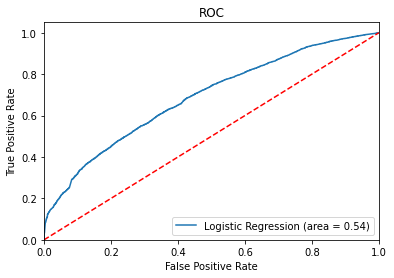

In [25]:
logit_roc_auc = roc_auc_score(y_test, clf_log.predict(X_test))
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, clf_log.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(log_fpr, log_tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Decision Tree


In [0]:
train_set

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,churn
subid,,,,,,,,,,,
29726122,0,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.000000,0,0,1.0
20299962,0,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.000000,0,0,1.0
21511732,0,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,0.555556,1,0,1.0
29576692,0,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.000000,0,1,1.0
21447938,0,4.935484,0.645161,3.741935,4.258065,0.064516,0.967742,1.000000,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
25927672,0,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.000000,0,1,1.0
29190645,0,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,0.967742,0,0,1.0
28920930,0,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.967742,1,0,0.0


In [0]:
X = train_set.drop(columns = ['churn'])
y = train_set['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [0]:
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            del params['scale']
            
    clf_2 = DecisionTreeClassifier(**params)
    return cross_val_score(clf_2, X=X_train, y=y_train).mean()

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,10)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    #'scale': hp.choice('scale', [0, 1]),
    #'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
  acc = hyperopt_train_test(params)
  return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=50, trials=trials)
print(best)

100%|██████████| 50/50 [00:14<00:00,  3.47it/s, best loss: -0.7677779324689079]
{'criterion': 0, 'max_depth': 3, 'max_features': 8}


In [0]:
classifier_2 = DecisionTreeClassifier(criterion = 'gini',
                            max_depth = 3,
                            max_features = 8)

clf_2 = classifier_2.fit(X_train, y_train)

# Applying k-Fold Cross Validation

acc = cross_val_score(estimator = classifier_2, X = X_train, y = y_train, cv = 5, scoring='accuracy')
CrossValMean = acc.mean()

print("Final CrossValMean: ", CrossValMean)

CrossValSTD = acc.std()


print("Final CrossValstd: ", CrossValSTD)

Final CrossValMean:  0.7629988289849216
Final CrossValstd:  0.0015190521048184555


In [0]:
y_pred_tree = clf_2.predict(X_test)
y_pred_proba_tree = clf_2.predict_proba(X_test)
y_pred_1_tree = y_pred_proba_tree[:,1] > 0.5
print(classification_report(y_test,y_pred_1_tree))
#print(accuracy_score(y_test,y_pred))
print('auc = ',roc_auc_score(y_test,y_pred_proba_tree[:,1]))
print('f1score = ',f1_score(y_test,y_pred_1_tree))

              precision    recall  f1-score   support

         0.0       0.50      0.20      0.29      3617
         1.0       0.79      0.94      0.85     11269

    accuracy                           0.76     14886
   macro avg       0.65      0.57      0.57     14886
weighted avg       0.72      0.76      0.72     14886

auc =  0.6807832895276942
f1score =  0.8540645631657823


### important features

In [0]:
a = list(clf_2.feature_importances_)
a

[0.0,
 0.0,
 0.05624341949195557,
 0.46217381777192645,
 0.013804834566471743,
 0.0,
 0.0,
 0.16013439486886188,
 0.0,
 0.3076435333007844]

In [0]:
feature = list(train_set.columns)
feature.pop()
feature

['male_TF',
 'app_opens',
 'cust_service_mssgs',
 'num_videos_completed',
 'num_videos_more_than_30_seconds',
 'num_videos_rated',
 'num_series_started',
 'active_percentage',
 'OTT_usage',
 'expand_usage']

In [0]:
tree_important_feature = {}
for i in range(10):
  tree_important_feature[feature[i]]=a[i]

In [0]:
tree_important_feature

{'OTT_usage': 0.0,
 'active_percentage': 0.16013439486886188,
 'app_opens': 0.0,
 'cust_service_mssgs': 0.05624341949195557,
 'expand_usage': 0.3076435333007844,
 'male_TF': 0.0,
 'num_series_started': 0.0,
 'num_videos_completed': 0.46217381777192645,
 'num_videos_more_than_30_seconds': 0.013804834566471743,
 'num_videos_rated': 0.0}

In [0]:
import sklearn.datasets as datasets
breast_cancer = datasets.load_breast_cancer()

In [0]:
type(breast_cancer)

sklearn.utils.Bunch

In [0]:
feature

['male_TF',
 'app_opens',
 'cust_service_mssgs',
 'num_videos_completed',
 'num_videos_more_than_30_seconds',
 'num_videos_rated',
 'num_series_started',
 'active_percentage',
 'OTT_usage',
 'expand_usage',
 'churn']

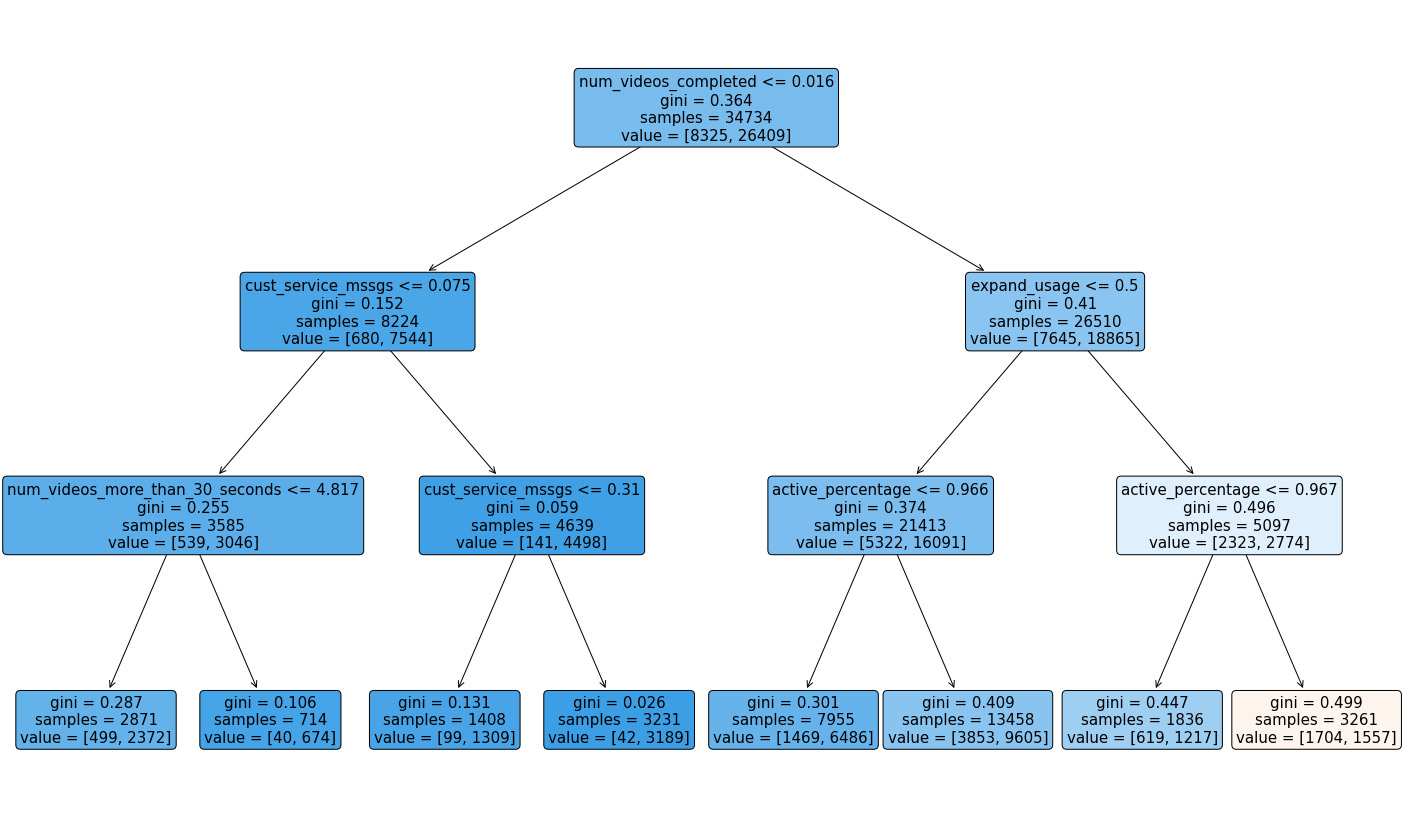

In [0]:
from sklearn.tree import plot_tree


plt.figure(figsize=(25,15))
a = plot_tree(clf_2, 
              feature_names=feature, 
              #class_names=, 
              filled=True, 
              rounded=True, 
              fontsize=15)

## ROC Curve


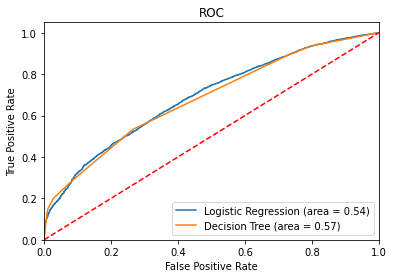

In [0]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

tree_roc_auc = roc_auc_score(y_test, clf_2.predict(X_test))
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, clf_2.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(tree_fpr, tree_tpr, label='Decision Tree (area = %0.2f)' % tree_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Fit the Prediction Set



In [0]:
eng_sub = pd.read_csv('eng_sub.csv',index_col=0)
eng_sub.set_index(keys = ['subid'],drop = True,inplace=True)

In [47]:
train_set

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,churn
subid,,,,,,,,,,,
29726122,0,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.000000,0,0,1.0
20299962,0,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.000000,0,0,1.0
21511732,0,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,0.555556,1,0,1.0
29576692,0,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.000000,0,1,1.0
21447938,0,4.935484,0.645161,3.741935,4.258065,0.064516,0.967742,1.000000,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
25927672,0,1.612903,0.225806,3.516129,4.258065,0.064516,1.000000,1.000000,0,1,1.0
29190645,0,2.000000,0.066667,0.533333,3.866667,0.000000,0.700000,0.967742,0,0,1.0
28920930,0,2.733333,0.200000,0.033333,4.133333,0.133333,0.166667,0.967742,1,0,0.0


In [41]:
prediction_set = eng_sub.loc[eng_sub['renew'].isnull()==True]

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,renew
subid,,,,,,,,,,,
29773460,0,4.000000,0.043478,0.956522,4.347826,0.000000,0.173913,1.000000,0,0,NaN
20668260,0,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0,0,NaN
26979346,0,0.920000,0.200000,1.400000,4.120000,0.040000,0.680000,0.862069,1,0,NaN
27312738,0,0.920000,0.040000,4.000000,4.320000,0.160000,0.560000,1.000000,0,0,NaN
21740883,0,4.481481,0.370370,3.185185,4.259259,0.000000,0.851852,0.964286,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22354444,0,0.500000,0.250000,0.000000,3.250000,0.000000,0.000000,0.210526,0,0,NaN
23988642,0,1.000000,0.250000,1.375000,4.187500,0.000000,1.000000,1.000000,1,0,NaN
26975049,1,3.518519,0.037037,2.074074,4.851852,0.037037,0.629630,1.000000,0,0,NaN


In [0]:
prediction_set.drop(columns=['renew'],inplace=True)
prediction_set

In [0]:
X = pd.concat([train_set.drop(columns = ['churn']), prediction_set], ignore_index=True)

In [49]:
X

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage
0,0,1.000000,0.258065,4.387097,4.387097,0.193548,1.000000,1.000000,0,0
1,0,1.709677,0.193548,0.580645,4.258065,0.000000,0.483871,1.000000,0,0
2,0,2.333333,0.266667,0.933333,3.733333,0.000000,0.666667,0.555556,1,0
3,0,2.000000,0.322581,4.225806,4.225806,0.064516,1.000000,1.000000,0,1
4,0,4.935484,0.645161,3.741935,4.258065,0.064516,0.967742,1.000000,1,0
...,...,...,...,...,...,...,...,...,...,...
53713,0,0.500000,0.250000,0.000000,3.250000,0.000000,0.000000,0.210526,0,0
53714,0,1.000000,0.250000,1.375000,4.187500,0.000000,1.000000,1.000000,1,0
53715,1,3.518519,0.037037,2.074074,4.851852,0.037037,0.629630,1.000000,0,0
53716,1,1.000000,0.333333,3.000000,4.190476,0.142857,0.666667,0.954545,0,0


In [0]:
X_train = train_set.drop(columns = ['churn'])
y_train = train_set['churn']
X_test = prediction_set

In [0]:
classifier = LogisticRegression(warm_start = True,
                            fit_intercept = True,
                            tol = 3.570394982708738e-05,
                            C = 0.3354621699047937,
                            solver = 'liblinear',
                            max_iter = 378,
                            verbose=0)

clf = classifier.fit(X_train, y_train)

In [0]:
y_pred_proba = clf.predict_proba(X_test)

In [71]:
y_pred_proba[:,1]

array([0.83970722, 0.87721606, 0.78947987, ..., 0.76374923, 0.787563  ,
       0.69161109])

In [0]:
y_pred_threshold_50 = y_pred_proba[:,1] > 0.5
y_pred_threshold_50 = np.array(pd.Series(y_pred_threshold_50).map({True : 1,False : 0}))
y_pred_threshold_67 = y_pred_proba[:,1] > 0.67
y_pred_threshold_67 = np.array(pd.Series(y_pred_threshold_67).map({True : 1,False : 0}))
y_pred_threshold_90 = y_pred_proba[:,1] > 0.9
y_pred_threshold_90 = np.array(pd.Series(y_pred_threshold_90).map({True : 1,False : 0}))

In [0]:
prediction_set['churn_proba'] = y_pred_proba[:,1]

In [0]:
prediction_set['churn_threshold_50'] = y_pred_threshold_50
prediction_set['churn_threshold_67'] = y_pred_threshold_67
prediction_set['churn_threshold_90'] = y_pred_threshold_90

In [80]:
prediction_set

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90
subid,,,,,,,,,,,,,,
29773460,0,4.000000,0.043478,0.956522,4.347826,0.000000,0.173913,1.000000,0,0,0.839707,1,1,0
20668260,0,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0,0,0.877216,1,1,0
26979346,0,0.920000,0.200000,1.400000,4.120000,0.040000,0.680000,0.862069,1,0,0.789480,1,1,0
27312738,0,0.920000,0.040000,4.000000,4.320000,0.160000,0.560000,1.000000,0,0,0.725932,1,1,0
21740883,0,4.481481,0.370370,3.185185,4.259259,0.000000,0.851852,0.964286,0,0,0.741849,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22354444,0,0.500000,0.250000,0.000000,3.250000,0.000000,0.000000,0.210526,0,0,0.919384,1,1,1
23988642,0,1.000000,0.250000,1.375000,4.187500,0.000000,1.000000,1.000000,1,0,0.739122,1,1,0
26975049,1,3.518519,0.037037,2.074074,4.851852,0.037037,0.629630,1.000000,0,0,0.763749,1,1,0


In [81]:
prediction_set.describe()

,male_TF,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,active_percentage,OTT_usage,expand_usage,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,0.153490,2.001623,0.374411,1.617508,4.025633,0.066609,0.504973,0.848719,0.417521,0.001464,0.805156,0.999512,0.893119,0.199122
std,0.360503,1.759772,0.621455,1.632789,0.975766,0.155284,0.410731,0.238617,0.493210,0.038241,0.101130,0.022089,0.309000,0.399388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.492671,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.062500,0.000000,4.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.717116,1.000000,1.000000,0.000000
50%,0.000000,1.288018,0.230769,1.000000,4.250000,0.000000,0.578947,1.000000,0.000000,0.000000,0.814592,1.000000,1.000000,0.000000
75%,0.000000,2.500000,0.428571,3.285714,4.400000,0.066667,0.928571,1.000000,1.000000,0.000000,0.890040,1.000000,1.000000,0.000000
max,1.000000,22.470588,12.000000,7.000000,12.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.999994,1.000000,1.000000,1.000000


In [0]:
prediction_set.to_csv("prediction_set.csv")

# CLV


In [84]:
prediction_set.columns

Index(['male_TF', 'app_opens', 'cust_service_mssgs', 'num_videos_completed',
       'num_videos_more_than_30_seconds', 'num_videos_rated',
       'num_series_started', 'active_percentage', 'OTT_usage', 'expand_usage',
       'churn_proba', 'churn_threshold_50', 'churn_threshold_67',
       'churn_threshold_90'],
      dtype='object')

In [0]:
prediction_set.drop(columns = ['male_TF', 'app_opens', 'cust_service_mssgs', 'num_videos_completed',
       'num_videos_more_than_30_seconds', 'num_videos_rated',
       'num_series_started', 'active_percentage', 'OTT_usage', 'expand_usage'],inplace = True)

In [87]:
prediction_set

,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90
subid,,,,
29773460,0.839707,1,1,0
20668260,0.877216,1,1,0
26979346,0.789480,1,1,0
27312738,0.725932,1,1,0
21740883,0.741849,1,1,0
...,...,...,...,...
22354444,0.919384,1,1,1
23988642,0.739122,1,1,0
26975049,0.763749,1,1,0


## Revenue


In [0]:
rev = service.groupby(['subid'])['revenue_net_1month'].agg(['min','max'])
rev['difference'] = rev['max'] - rev['min']

In [99]:
rev.describe()

,min,max,difference
count,1.369360e+06,1.369360e+06,1369360.0
mean,1.563467e+00,1.563467e+00,0.0
std,2.168659e+00,2.168659e+00,0.0
min,-7.596900e+00,-7.596900e+00,0.0
25%,0.000000e+00,0.000000e+00,0.0
50%,0.000000e+00,0.000000e+00,0.0
75%,3.706700e+00,3.706700e+00,0.0
max,1.038610e+01,1.038610e+01,0.0


In [0]:
rev=rev.iloc[:,:1]

In [0]:
rev.columns = ['rev']

In [102]:
rev

,rev
subid,
20000002,0.0000
20000003,0.0000
20000007,0.0000
20000014,0.0000
20000031,0.0000
...,...
29999986,2.4589
29999991,0.0000
29999993,0.0000


In [0]:
rev_churn = pd.merge(rev,prediction_set,on=['subid'], how='right')

In [106]:
rev_churn.describe()

,rev,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,4.184543,0.805156,0.999512,0.893119,0.199122
std,1.380075,0.101130,0.022089,0.309000,0.399388
min,-5.578400,0.492671,0.000000,0.000000,0.000000
25%,4.587500,0.717116,1.000000,1.000000,0.000000
50%,4.587500,0.814592,1.000000,1.000000,0.000000
75%,4.734300,0.890040,1.000000,1.000000,0.000000
max,5.211400,0.999994,1.000000,1.000000,1.000000


In [0]:
subscribers.drop(columns = ['package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type',  'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type'],inplace = True)

In [114]:
subscribers

,subid,attribution_technical,monthly_price,discount_price,account_creation_date,revenue_net,join_fee
162502,21724479,facebook,4.7343,4.5141,2020-01-24 21:44:16,NaN,NaN
380374,23383224,facebook,4.7343,4.5141,2020-03-01 15:44:35,0.0000,0.3303
496617,26844789,organic,4.7343,4.5141,2019-12-07 16:37:06,0.0000,0.1101
356799,29417030,search,4.7343,4.5141,2020-01-27 16:09:32,0.0000,0.0367
681701,26723159,discovery,4.7343,4.5141,2019-10-05 12:57:07,0.0000,0.0367
...,...,...,...,...,...,...,...
509326,21434712,facebook,4.7343,4.5141,2019-11-17 14:12:33,0.0000,0.3303
229587,25843074,google_organic,4.7343,4.5141,2019-12-06 18:02:13,4.5875,0.3303
281340,24799085,facebook,4.7343,4.5141,2019-12-21 19:40:44,0.0000,0.0367
87198,21308040,facebook,4.7343,4.5141,2020-01-17 23:58:51,NaN,NaN


In [116]:
subscribers.describe()

,subid,monthly_price,discount_price,revenue_net,join_fee
count,2.276280e+05,227628.000000,227628.000000,192724.000000,192724.000000
mean,2.498624e+07,4.732049,4.512188,1.557353,0.115145
std,2.885543e+06,0.101049,0.097078,3.068829,0.176971
min,2.000001e+07,0.807400,0.770700,-5.982100,-0.660600
25%,2.248998e+07,4.734300,4.514100,0.000000,0.036700
50%,2.497011e+07,4.734300,4.514100,0.000000,0.036700
75%,2.749020e+07,4.734300,4.514100,2.532300,0.110100
max,2.999998e+07,5.101300,5.027900,15.634200,0.734000


In [0]:
rev_churn_sub = pd.merge(subscribers,rev_churn,on=['subid'], how='right')

In [118]:
rev_churn_sub

,subid,attribution_technical,monthly_price,discount_price,account_creation_date,revenue_net,join_fee,rev,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90
0,29773460,organic,4.7343,4.5141,2020-03-18 23:06:25,NaN,NaN,4.5875,0.839707,1,1,0
1,20668260,facebook,4.7343,4.5141,2020-03-08 20:42:05,0.0000,0.1101,0.0000,0.877216,1,1,0
2,26979346,email,4.7343,4.5141,2020-03-13 22:30:41,NaN,NaN,4.5875,0.789480,1,1,0
3,27312738,organic,4.7343,4.5141,2020-03-16 11:35:59,NaN,NaN,4.5875,0.725932,1,1,0
4,21740883,google_organic,4.7343,4.5141,2020-03-13 03:03:59,NaN,NaN,4.5875,0.741849,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4093,22354444,facebook,4.7343,4.5141,2020-03-10 10:08:49,NaN,NaN,4.5875,0.919384,1,1,1
4094,23988642,organic,4.7343,4.5141,2020-03-26 18:45:15,4.9178,0.3303,4.9178,0.739122,1,1,0
4095,26975049,email,4.7343,4.5141,2020-03-14 19:01:52,NaN,NaN,5.0646,0.763749,1,1,0
4096,27830586,facebook,4.7343,4.5141,2020-03-19 13:57:31,4.5875,0.3303,4.5875,0.787563,1,1,0


In [125]:
rev_churn_sub['account_creation_date'].sort_values()

758    2020-02-12 18:57:07
3470   2020-02-13 02:05:11
3695   2020-02-13 02:52:06
1560   2020-02-13 17:02:52
2490   2020-02-14 12:31:36
               ...        
3221   2020-03-27 23:36:13
429    2020-03-27 23:43:28
1018   2020-03-27 23:47:11
1549   2020-03-27 23:51:37
3790   2020-03-27 23:52:29
Name: account_creation_date, Length: 4098, dtype: datetime64[ns]

In [123]:
rev_churn_sub['attribution_technical'].value_counts()

facebook                   962
organic                    760
email                      566
google_organic             416
search                     397
affiliate                  232
brand sem intent google    223
referral                   167
pinterest                   80
other                       55
brand sem intent bing       37
facebook_organic            33
podcast                     32
bing_organic                30
youtube                     24
bing                        20
email_blast                 17
display                     13
vod                          9
appstore                     7
discovery                    7
internal                     6
ott                          3
direct_mail                  1
pinterest_organic            1
Name: attribution_technical, dtype: int64

In [0]:
rev_churn_sub['diff']=rev_churn_sub['revenue_net'] - rev_churn_sub['rev']

In [122]:
rev_churn_sub.describe()

,subid,monthly_price,discount_price,revenue_net,join_fee,rev,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90,diff
count,4.098000e+03,4098.000000,4098.000000,2365.000000,2365.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,2365.000000
mean,2.502020e+07,4.734157,4.513957,3.921919,0.256264,4.184543,0.805156,0.999512,0.893119,0.199122,-0.132244
std,2.887238e+06,0.006485,0.006485,1.725608,0.186604,1.380075,0.101130,0.022089,0.309000,0.399388,0.926115
min,2.000557e+07,4.440700,4.220500,-5.725200,0.000000,-5.578400,0.492671,0.000000,0.000000,0.000000,-10.753100
25%,2.249845e+07,4.734300,4.514100,4.587500,0.036700,4.587500,0.717116,1.000000,1.000000,0.000000,0.000000
50%,2.496290e+07,4.734300,4.514100,4.587500,0.330300,4.587500,0.814592,1.000000,1.000000,0.000000,0.000000
75%,2.751237e+07,4.734300,4.514100,4.734300,0.330300,4.734300,0.890040,1.000000,1.000000,0.000000,0.000000
max,2.999994e+07,4.734300,4.514100,5.211400,0.660600,5.211400,0.999994,1.000000,1.000000,1.000000,5.064600


In [134]:
rev_churn_sub

,subid,attribution_technical,monthly_price,discount_price,account_creation_date,revenue_net,join_fee,rev,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90,diff
0,29773460,organic,4.7343,4.5141,2020-03-18 23:06:25,NaN,NaN,4.5875,0.839707,1,1,0,NaN
1,20668260,facebook,4.7343,4.5141,2020-03-08 20:42:05,0.0000,0.1101,0.0000,0.877216,1,1,0,0.0
2,26979346,email,4.7343,4.5141,2020-03-13 22:30:41,NaN,NaN,4.5875,0.789480,1,1,0,NaN
3,27312738,organic,4.7343,4.5141,2020-03-16 11:35:59,NaN,NaN,4.5875,0.725932,1,1,0,NaN
4,21740883,google_organic,4.7343,4.5141,2020-03-13 03:03:59,NaN,NaN,4.5875,0.741849,1,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,22354444,facebook,4.7343,4.5141,2020-03-10 10:08:49,NaN,NaN,4.5875,0.919384,1,1,1,NaN
4094,23988642,organic,4.7343,4.5141,2020-03-26 18:45:15,4.9178,0.3303,4.9178,0.739122,1,1,0,0.0
4095,26975049,email,4.7343,4.5141,2020-03-14 19:01:52,NaN,NaN,5.0646,0.763749,1,1,0,NaN
4096,27830586,facebook,4.7343,4.5141,2020-03-19 13:57:31,4.5875,0.3303,4.5875,0.787563,1,1,0,0.0


In [0]:
rev_churn_sub['month'] = pd.DatetimeIndex(rev_churn_sub['account_creation_date']).month

## Cost


In [0]:
CAC.reset_index(level=0, inplace=True)

In [0]:
CAC['month'] = pd.DatetimeIndex(CAC['date']).month

In [144]:
CAC

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral,month
0,2019-06-30,64.339909,242.718447,160.185185,108.629442,152.564103,96.330275,159.459459,277.272727,6
1,2019-07-31,5.993407,23.190184,13.027108,10.191388,14.302741,19.735099,7.566204,12.500000,7
2,2019-08-31,5.306951,24.611902,9.334709,11.240106,8.565423,34.647739,9.733124,13.051823,8
3,2019-09-30,7.994779,31.322314,10.205184,13.921569,15.399061,46.586599,11.605416,12.714777,9
4,2019-10-31,5.406260,32.971800,9.001286,13.358302,16.052632,33.060389,9.824047,13.799622,10
5,2019-11-30,4.317045,29.373065,8.525896,10.640394,22.986248,15.580286,10.606061,12.436116,11
6,2019-12-31,5.534022,28.427344,8.514589,9.087188,21.415929,8.515815,8.460635,12.012012,12
7,2020-01-31,7.791382,31.883446,8.249448,8.644326,13.314711,8.571429,8.180708,12.671233,1
8,2020-02-29,6.221833,24.179293,7.000000,9.249787,10.135135,4.545455,9.411765,11.149228,2
9,2020-03-31,7.127304,22.241232,7.339153,12.011331,10.857495,5.357143,12.967033,17.605634,3


In [0]:
cac = CAC.iloc[8:,1:]

In [148]:
cac.columns

Index(['facebook', 'email', 'search', 'brand sem intent google', 'affiliate',
       'email_blast', 'pinterest', 'referral', 'month'],
      dtype='object')

In [0]:
cac = cac.melt(id_vars='month', 
        var_name="attribution_technical", 
        value_name="cost")

In [153]:
cac

,month,attribution_technical,cost
0,2,facebook,6.221833
1,3,facebook,7.127304
2,2,email,24.179293
3,3,email,22.241232
4,2,search,7.000000
5,3,search,7.339153
6,2,brand sem intent google,9.249787
7,3,brand sem intent google,12.011331
8,2,affiliate,10.135135
9,3,affiliate,10.857495


In [0]:
rev_churn_cost = pd.merge(cac,rev_churn_sub,on=['month','attribution_technical'], how='right')

In [165]:
rev_churn_cost

,month,attribution_technical,cost,subid,monthly_price,discount_price,account_creation_date,revenue_net,join_fee,rev,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90,diff
0,2,facebook,6.221833,21358385,4.7343,4.5141,2020-02-29 20:41:33,NaN,NaN,4.5875,0.946245,1,1,1,NaN
1,2,facebook,6.221833,28779663,4.7343,4.5141,2020-02-22 13:16:34,NaN,NaN,4.5875,0.884378,1,1,0,NaN
2,2,facebook,6.221833,23536740,4.7343,4.5141,2020-02-17 22:00:03,NaN,NaN,4.8811,0.897786,1,1,0,NaN
3,2,facebook,6.221833,27320983,4.7343,4.5141,2020-02-29 21:51:06,NaN,NaN,4.7343,0.877216,1,1,0,NaN
4,2,facebook,6.221833,25421133,4.7343,4.5141,2020-02-29 12:58:21,4.9545,0.3303,4.9545,0.871564,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,2,bing,NaN,22507106,4.7343,4.5141,2020-02-19 01:34:13,4.7343,0.3670,4.7343,0.884378,1,1,0,0.0
4094,2,ott,NaN,29310734,4.7343,4.5141,2020-02-27 02:36:02,4.5875,0.0367,4.5875,0.871564,1,1,0,0.0
4095,2,brand sem intent bing,NaN,26360091,4.7343,4.5141,2020-02-23 01:28:41,4.5875,0.3303,4.5875,0.904478,1,1,1,0.0
4096,2,brand sem intent bing,NaN,23909631,4.7343,4.5141,2020-02-23 17:07:14,4.7343,0.6606,4.7343,0.919154,1,1,1,0.0


For the rest channels, calculate the average spending for each month. Average CAC during 2020-02 is 10; Average CAC during 2020-03 is 11.67.



In [0]:
rev_churn_cost.loc[(rev_churn_cost['month']==2)&(rev_churn_cost['cost'].isnull()==True),'cost'] = 10
rev_churn_cost.loc[(rev_churn_cost['month']==3)&(rev_churn_cost['cost'].isnull()==True),'cost'] = 11.67

In [171]:
rev_churn_cost

,month,attribution_technical,cost,subid,monthly_price,discount_price,account_creation_date,revenue_net,join_fee,rev,churn_proba,churn_threshold_50,churn_threshold_67,churn_threshold_90,diff
0,2,facebook,6.221833,21358385,4.7343,4.5141,2020-02-29 20:41:33,NaN,NaN,4.5875,0.946245,1,1,1,NaN
1,2,facebook,6.221833,28779663,4.7343,4.5141,2020-02-22 13:16:34,NaN,NaN,4.5875,0.884378,1,1,0,NaN
2,2,facebook,6.221833,23536740,4.7343,4.5141,2020-02-17 22:00:03,NaN,NaN,4.8811,0.897786,1,1,0,NaN
3,2,facebook,6.221833,27320983,4.7343,4.5141,2020-02-29 21:51:06,NaN,NaN,4.7343,0.877216,1,1,0,NaN
4,2,facebook,6.221833,25421133,4.7343,4.5141,2020-02-29 12:58:21,4.9545,0.3303,4.9545,0.871564,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,2,bing,10.000000,22507106,4.7343,4.5141,2020-02-19 01:34:13,4.7343,0.3670,4.7343,0.884378,1,1,0,0.0
4094,2,ott,10.000000,29310734,4.7343,4.5141,2020-02-27 02:36:02,4.5875,0.0367,4.5875,0.871564,1,1,0,0.0
4095,2,brand sem intent bing,10.000000,26360091,4.7343,4.5141,2020-02-23 01:28:41,4.5875,0.3303,4.5875,0.904478,1,1,1,0.0
4096,2,brand sem intent bing,10.000000,23909631,4.7343,4.5141,2020-02-23 17:07:14,4.7343,0.6606,4.7343,0.919154,1,1,1,0.0


In [0]:
rev_churn_cost['clv']=rev_churn_cost['rev'] * (1.008/(1.008-rev_churn_cost['churn_proba'])) - rev_churn_cost['cost']

In [176]:
rev_churn_cost['clv'].describe()

count    4098.000000
mean       14.276564
std        23.995770
min       -66.969989
25%         2.013305
50%         9.280765
75%        24.838254
max       565.431796
Name: clv, dtype: float64

In [0]:
rev_churn_cost.to_csv('rev_churn_cost.csv')